In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
from findpoint import findpoint
import ModelEvaLib as me

In [2]:
chemfile = xr.open_dataset('F:/Data/case_anqing/April/April_chem.nc')

O3 = chemfile.O3
NO2 = chemfile.NO2

lat = chemfile.latitude
lon = chemfile.longitude

In [3]:
com = O3 + NO2
com

<xarray.DataArray (time: 720, level: 38, y: 138, x: 135)>
array([[[[ 148.92032 ,  157.5086  ,  160.7516  , ...,  123.44462 ,
           124.11073 ,  122.714455],
         [ 139.51581 ,  154.8238  ,  159.76883 , ...,  122.040474,
           121.65727 ,  123.90857 ],
         [ 137.32191 ,  143.29364 ,  150.86983 , ...,  125.82199 ,
           120.00894 ,  119.92543 ],
         ...,
         [  72.35003 ,   71.76982 ,   71.09493 , ...,   71.77226 ,
            70.754074,   67.19743 ],
         [  70.85718 ,   69.558975,   67.922966, ...,   83.8201  ,
            82.18465 ,   83.60721 ],
         [  67.894325,   67.11071 ,   66.37703 , ...,   85.9794  ,
            83.740875,   86.199066]],

        [[ 156.1758  ,  162.40271 ,  162.31038 , ...,  124.198456,
           125.125145,  123.399734],
         [ 154.4578  ,  159.55746 ,  161.86519 , ...,  123.02432 ,
           122.832375,  124.49878 ],
         [ 160.12659 ,  159.07487 ,  161.26884 , ...,  127.50886 ,
           121.89992 ,  121.61272 ],
...
         [ 900.12225 ,  896.03    ,  894.0712  , ...,  762.03467 ,
           755.4035  ,  751.70593 ],
         [ 877.514   ,  873.8477  ,  872.2524  , ...,  766.85986 ,
           761.8644  ,  756.57764 ],
         [ 877.0845  ,  873.73956 ,  872.36053 , ...,  769.744   ,
           766.0585  ,  761.36017 ]],

        [[1652.0121  , 1663.6956  , 1686.3212  , ..., 1601.2329  ,
          1605.1824  , 1611.7894  ],
         [1623.2456  , 1633.7523  , 1652.5663  , ..., 1602.4725  ,
          1603.9718  , 1606.6874  ],
         [1620.4427  , 1629.1472  , 1640.1075  , ..., 1610.5502  ,
          1608.6947  , 1608.176   ],
         ...,
         [1857.8586  , 1855.2142  , 1852.3933  , ..., 1482.7362  ,
          1474.853   , 1463.854   ],
         [1865.9712  , 1861.5597  , 1857.0718  , ..., 1486.7192  ,
          1485.9052  , 1483.6163  ],
         [1866.7478  , 1864.4814  , 1861.1504  , ..., 1483.6534  ,
          1484.7914  , 1484.7455  ]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-01 ... 2023-04-30T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 135.8 101.5 72.89
    latitude   (y, x) float32 29.01 29.01 29.01 29.01 ... 32.7 32.7 32.7 32.7
    longitude  (y, x) float32 114.7 114.7 114.7 114.8 ... 119.0 119.0 119.1
Dimensions without coordinates: y, x

In [4]:
obspath = 'F:/Data/case_anqing/April/obsdata/all/'
sitename = [os.path.splitext(filename)[0] for filename in os.listdir(obspath) if filename.endswith('.xlsx')]
siteloc = pd.read_excel('F:/Data/case_anqing/April/obsdata/安庆市站点坐标.xlsx',header=0,index_col=0)
lono = siteloc['经度']
lato = siteloc['纬度']

dfO3 = pd.DataFrame(columns=sitename,index=pd.date_range('2023-04-01','2023-04-30T23',freq='h'))
dfNO2 = pd.DataFrame(columns=sitename,index=pd.date_range('2023-04-01','2023-04-30T23',freq='h'))

for name in sitename:
    obsxlsx = pd.read_excel(obspath + name + '.xlsx',index_col=0)
    dfO3[name]=obsxlsx['O3']
    dfNO2[name]=obsxlsx['NO2']

dfO3 = dfO3.interpolate(method='linear')
dfNO2 = dfNO2.interpolate(method='linear')

In [5]:
df = dfO3+dfNO2

In [6]:
x_index=[]
y_index=[]

for name in sitename:
    out_x, out_y = findpoint(lono[name],lato[name],com)
    x_index.append(out_x)
    y_index.append(out_y)
nr = com.isel(x=x_index, y=y_index)

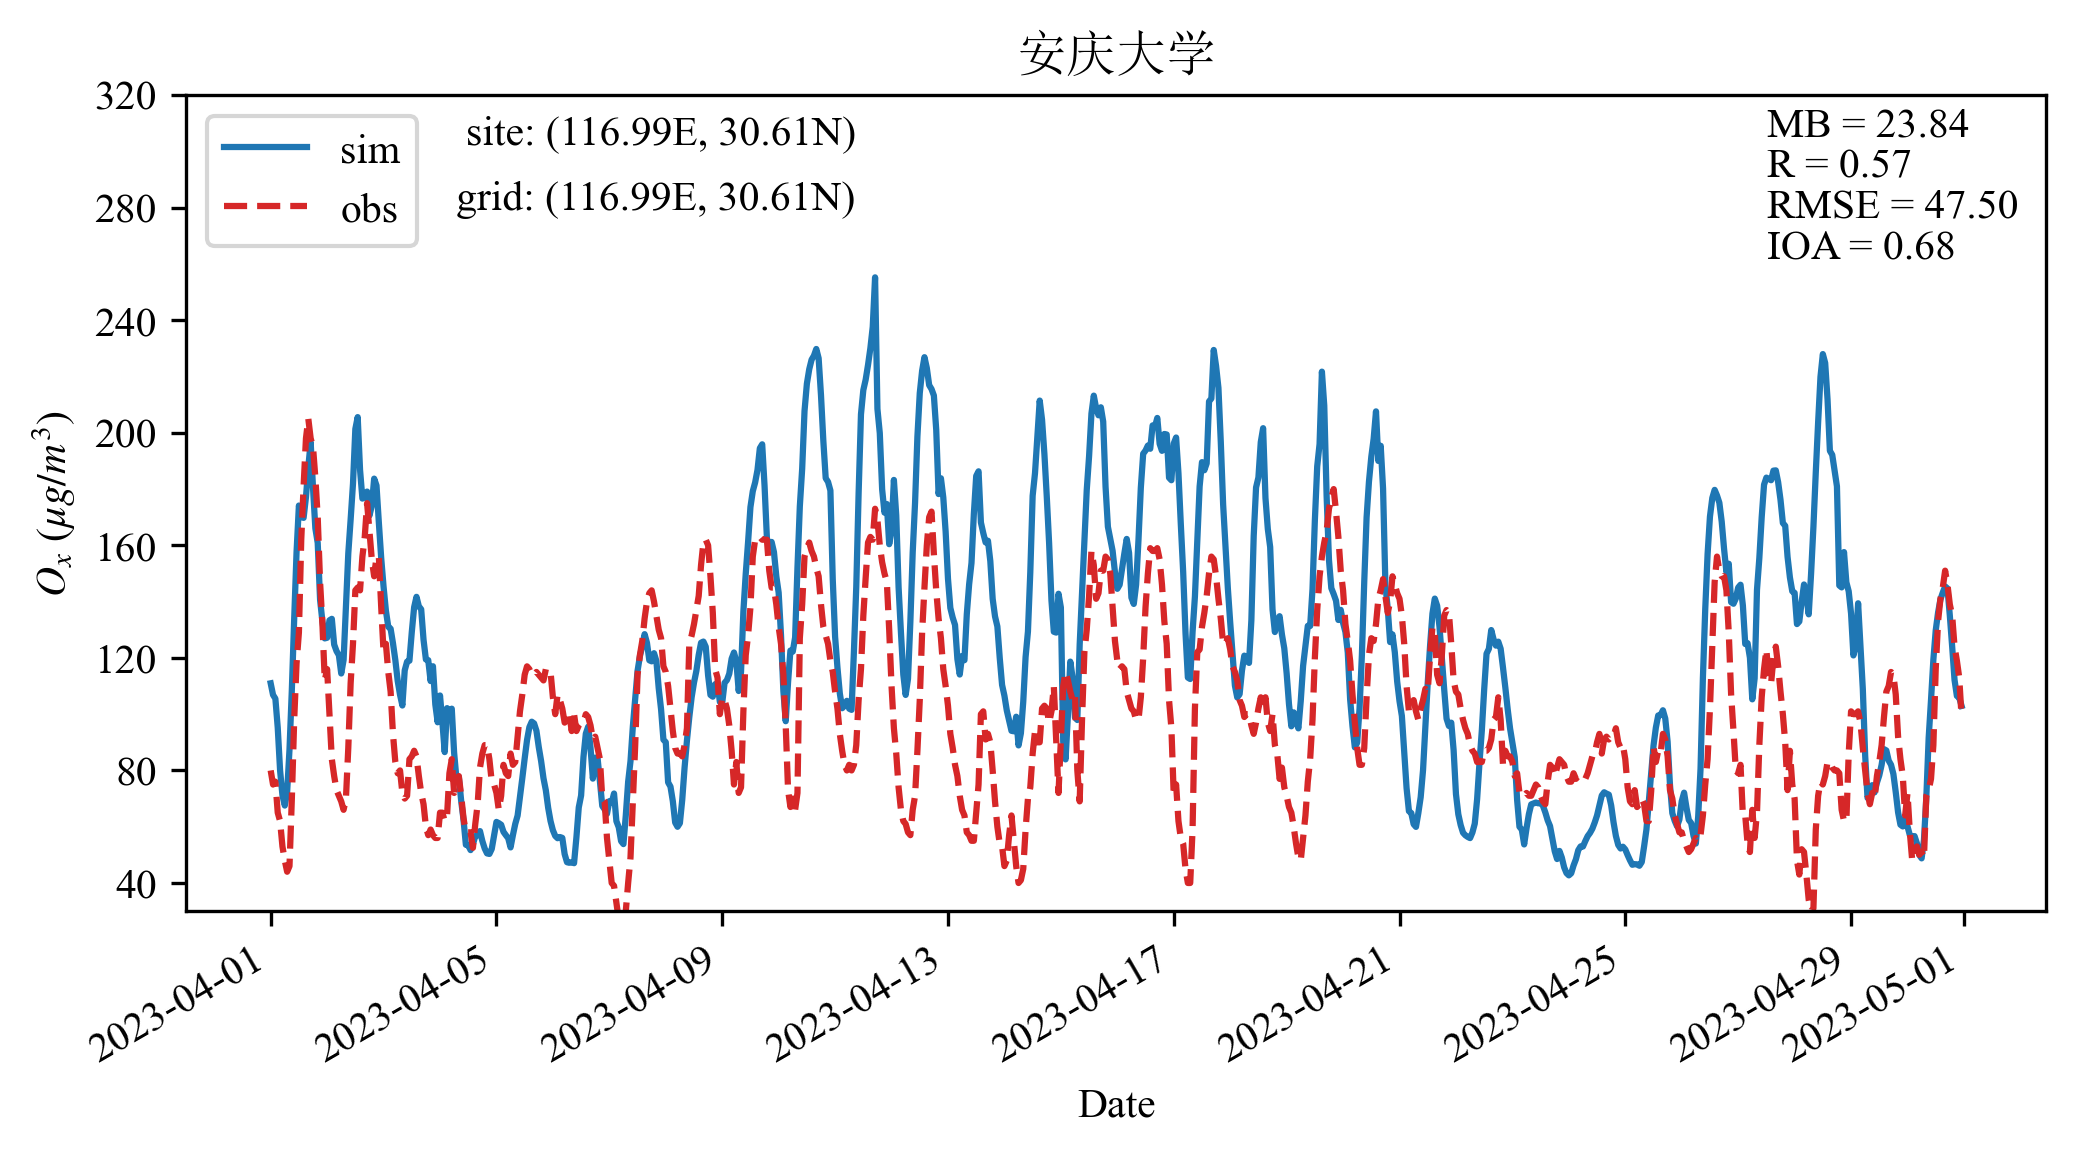

In [8]:
name = '安庆大学'
isite = 2

fig = plt.figure(figsize=(8,4),dpi=300)
ax = fig.subplots(1,1)

sim = nr[:,0,isite,isite]
obs = df[name]

sim.plot(ax=ax,linestyle='-',label='sim',color='tab:blue')
obs.plot(ax=ax,linestyle='--',label='obs',color='tab:red')

mb = np.array(np.mean(sim)-np.mean(obs))
r = pd.DataFrame({'A':sim,'B':obs}).corr().iloc[0,1]
rmse = me.cal_RMSE(obs,sim.data)
ioa = me.cal_IOA(obs,sim.data)

ax.text(x=0.85,y=0.95,s='MB = '+str(f"{mb:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.9,s='R = '+str(f"{r:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.85,s='RMSE = '+str(f"{rmse:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.8,s='IOA = '+str(f"{ioa:.2f}"),ha='left',transform=ax.transAxes)

ax.legend(loc=2)
ax.set_title(name,fontdict={'fontfamily':'SimSun'})
loctxt = 'site: ('+str(f"{lono[name]:.2f}")+'E, '+str(f"{lato[name]:.2f}")+'N)'
gridtxt = 'grid: ('+str(f"{sim.longitude.data:.2f}")+'E, '+str(f"{sim.latitude.data:.2f}")+'N)'
ax.text(x=0.36,y=0.94,s=loctxt,ha='right',transform=ax.transAxes)
ax.text(x=0.36,y=0.86,s=gridtxt,ha='right',transform=ax.transAxes)
ax.set_yticks(np.arange(0,321,40))
ax.set_ylim(30,320)
ax.set_ylabel('$O_x$ ($\mu$$g/m^3$)')
ax.set_xlabel('Date')

plt.show()

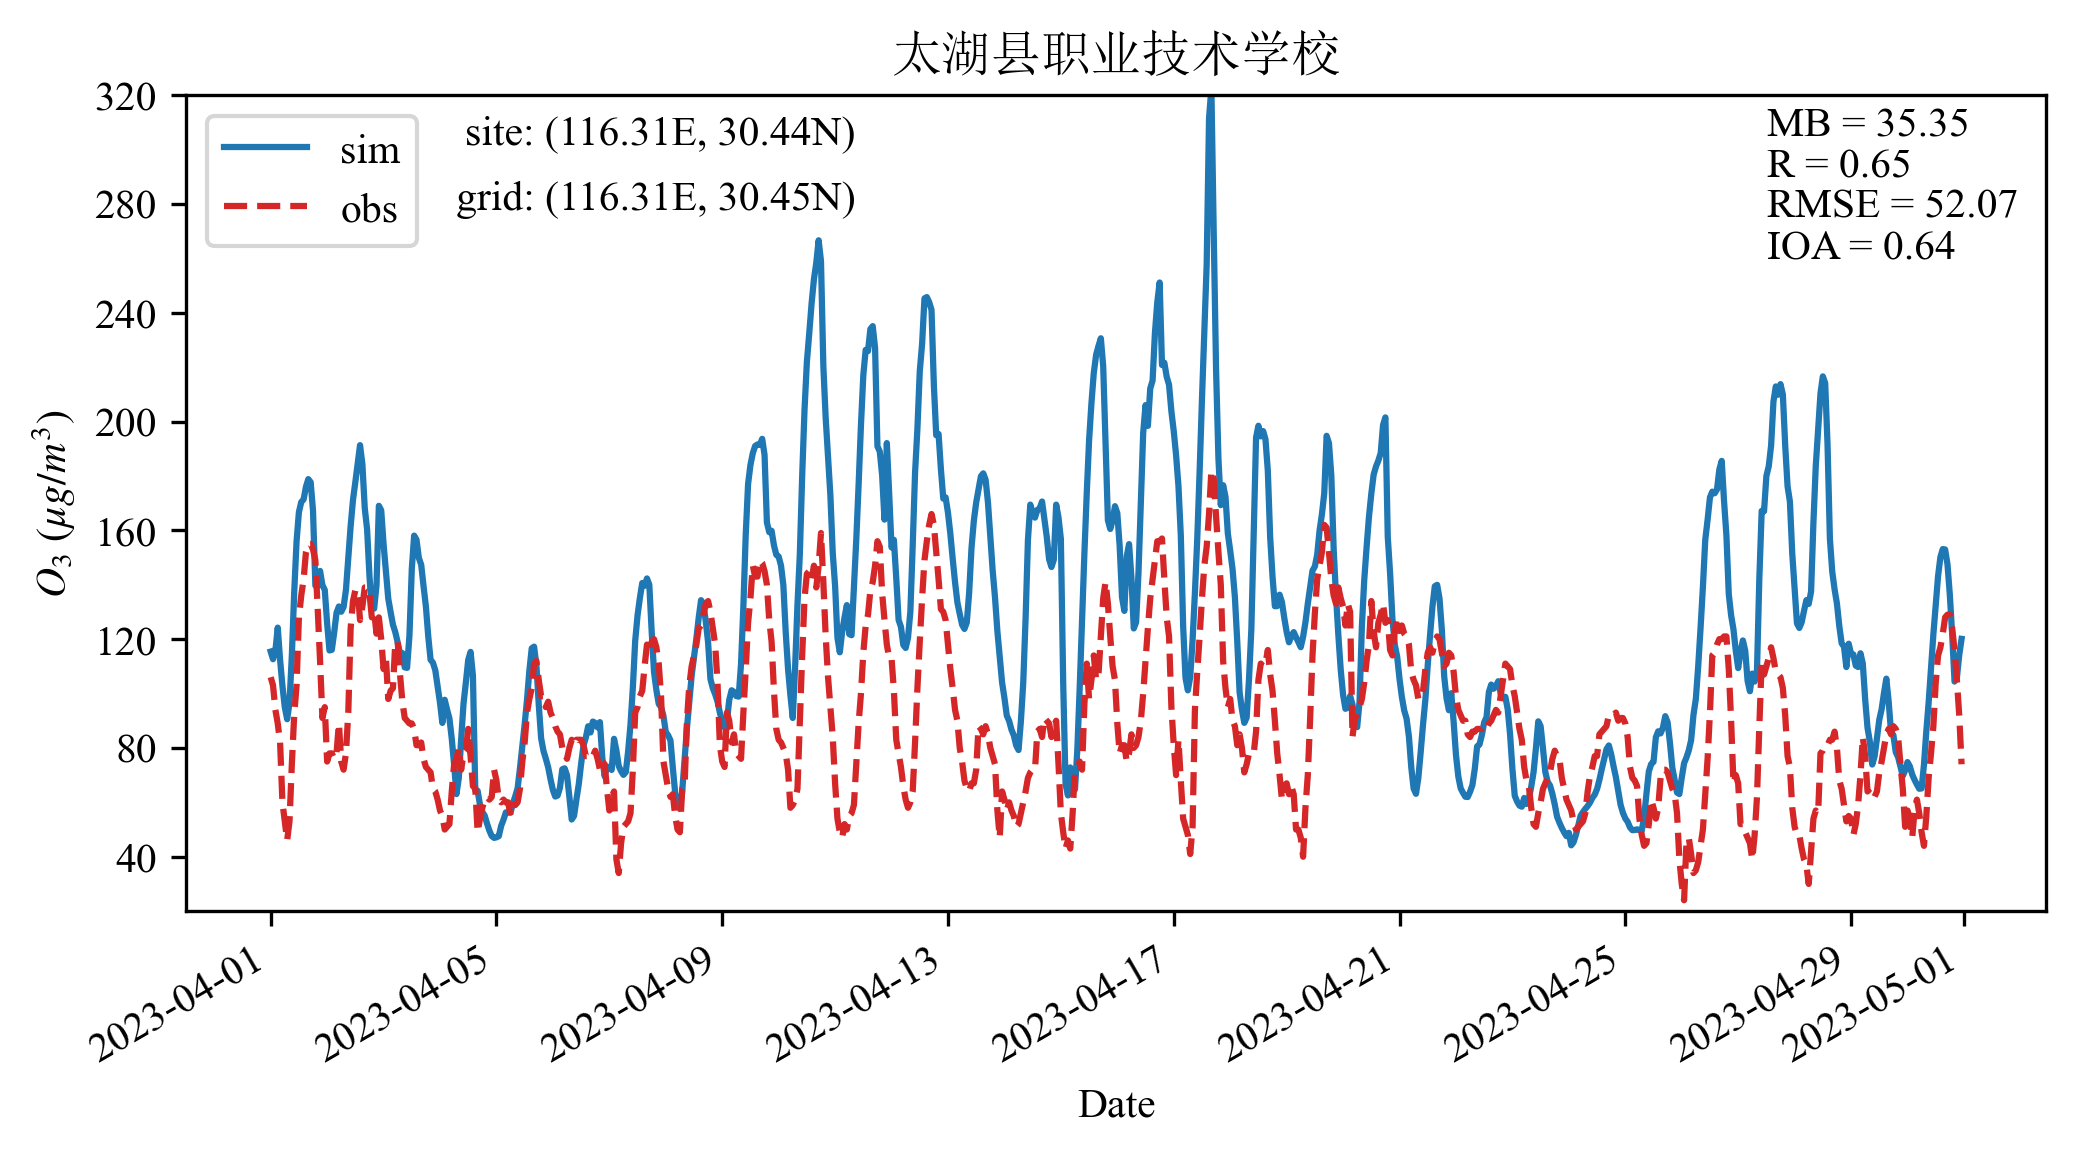

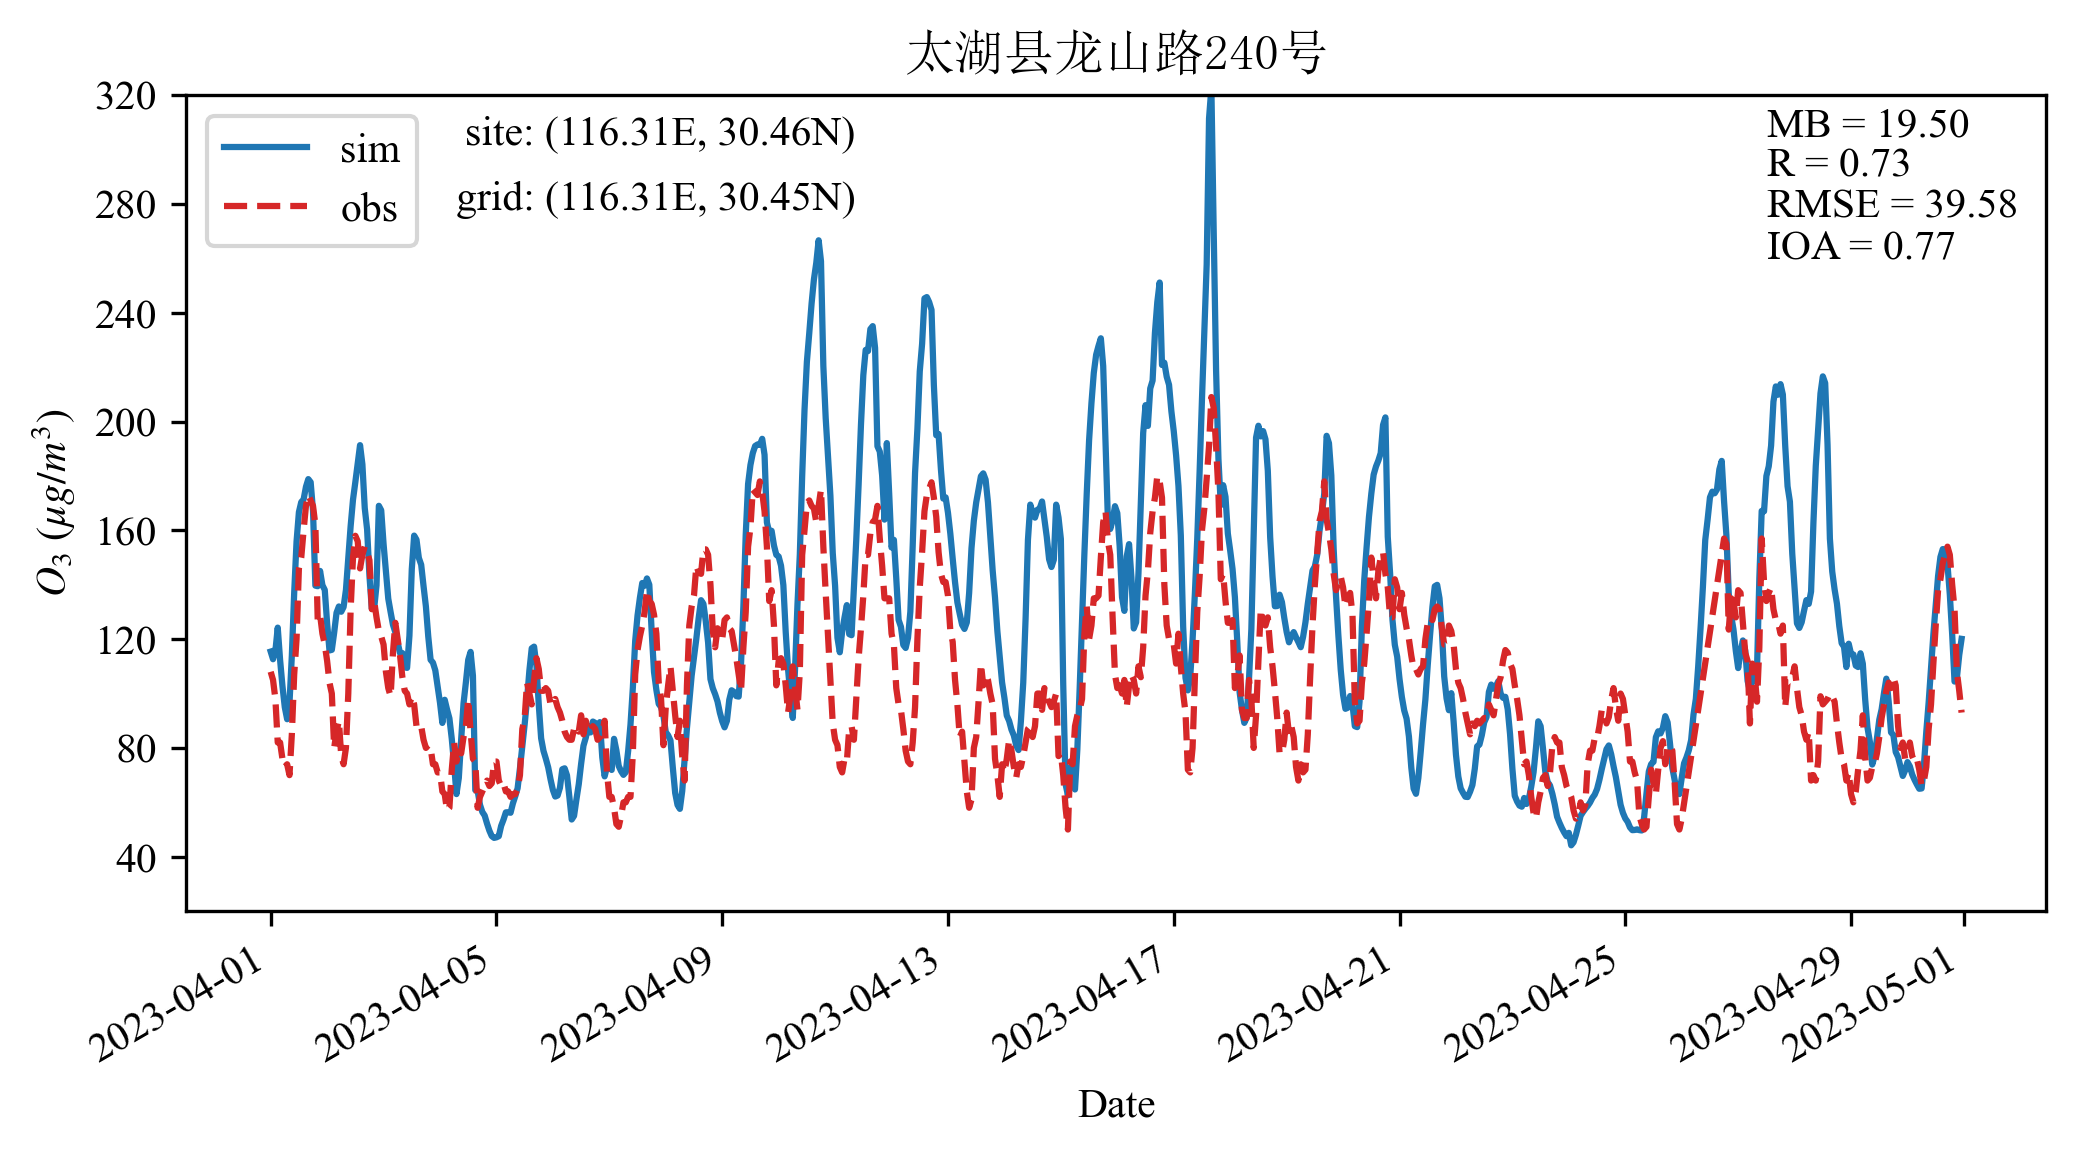

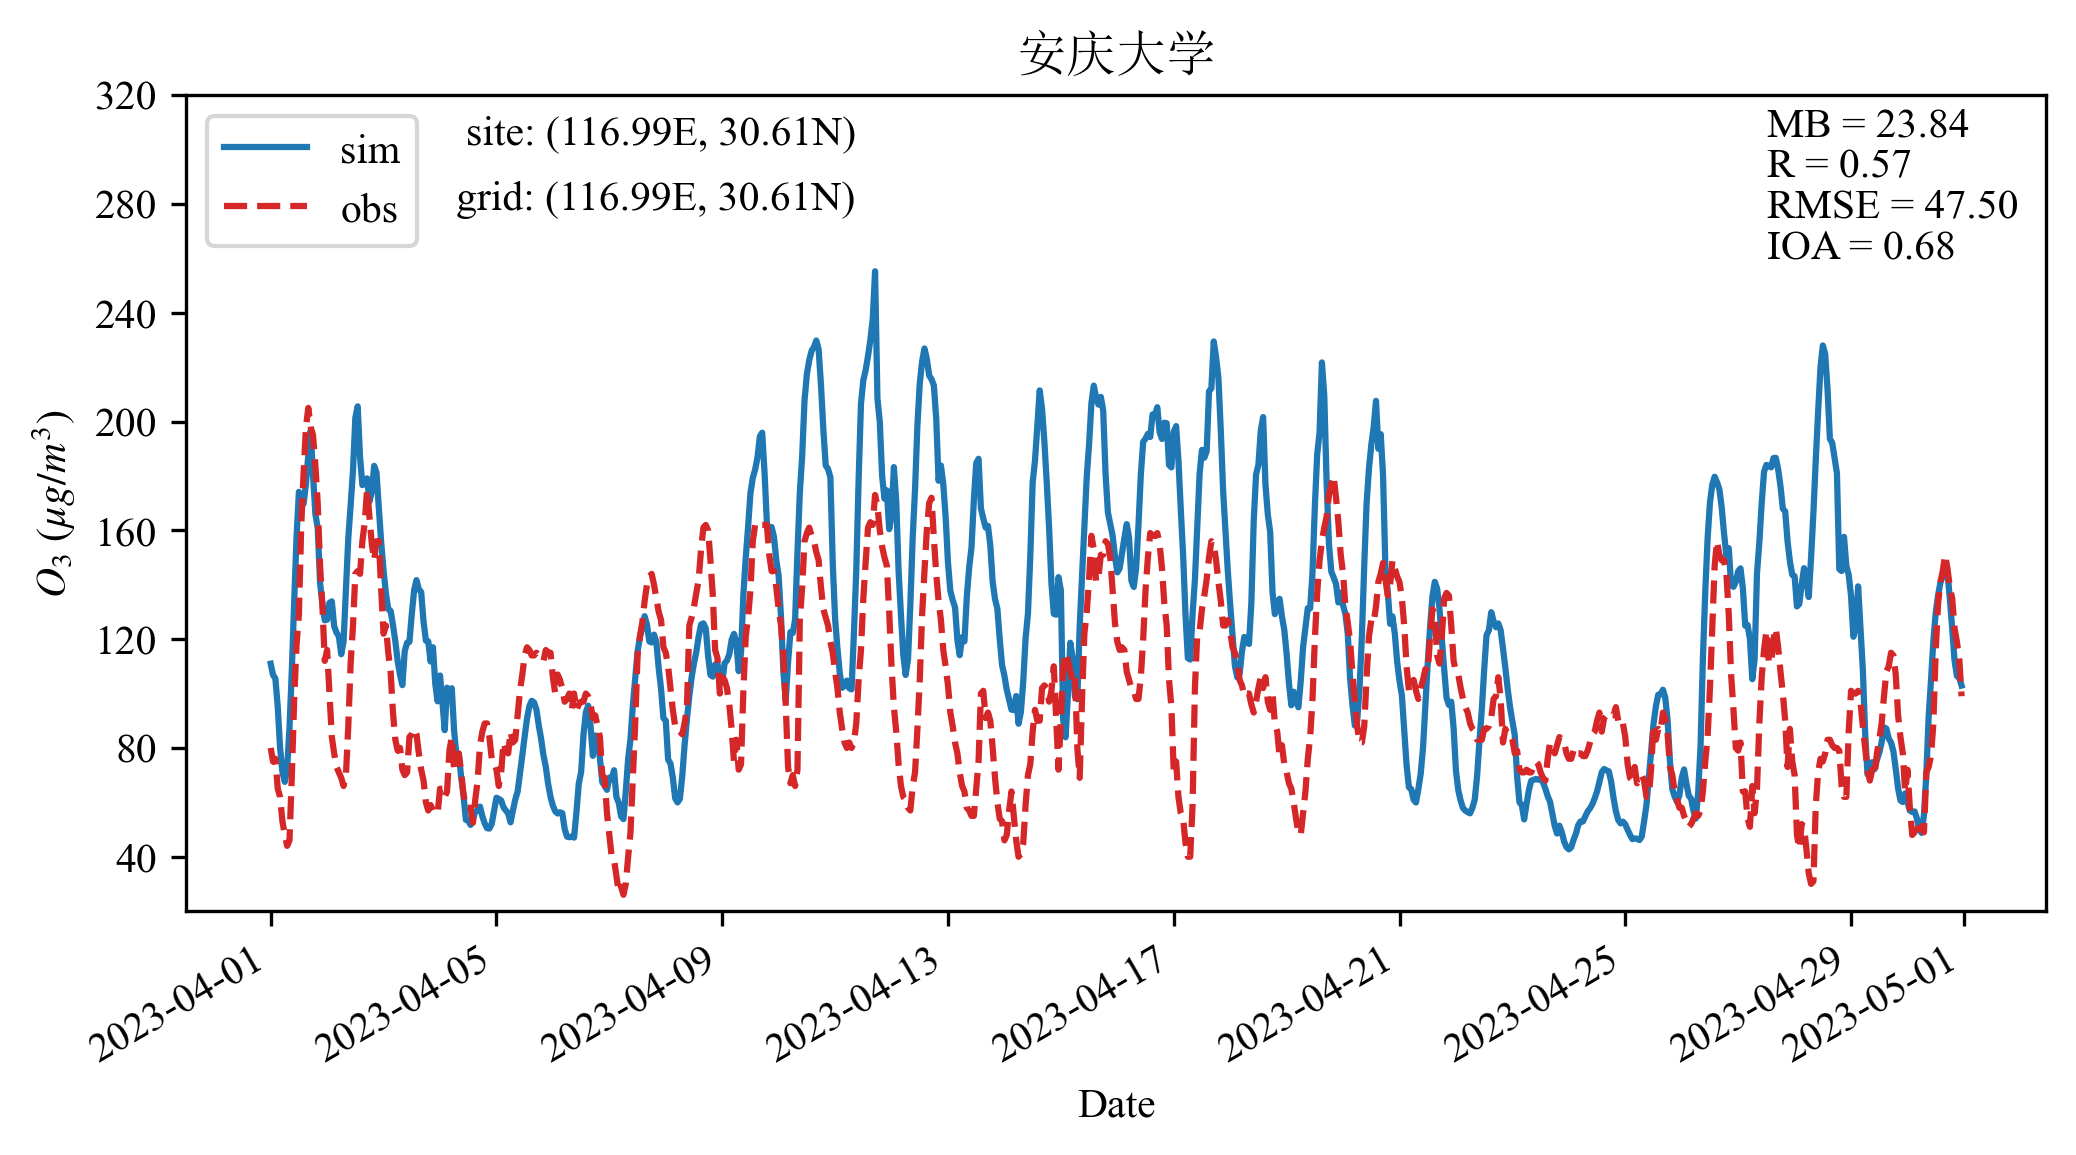

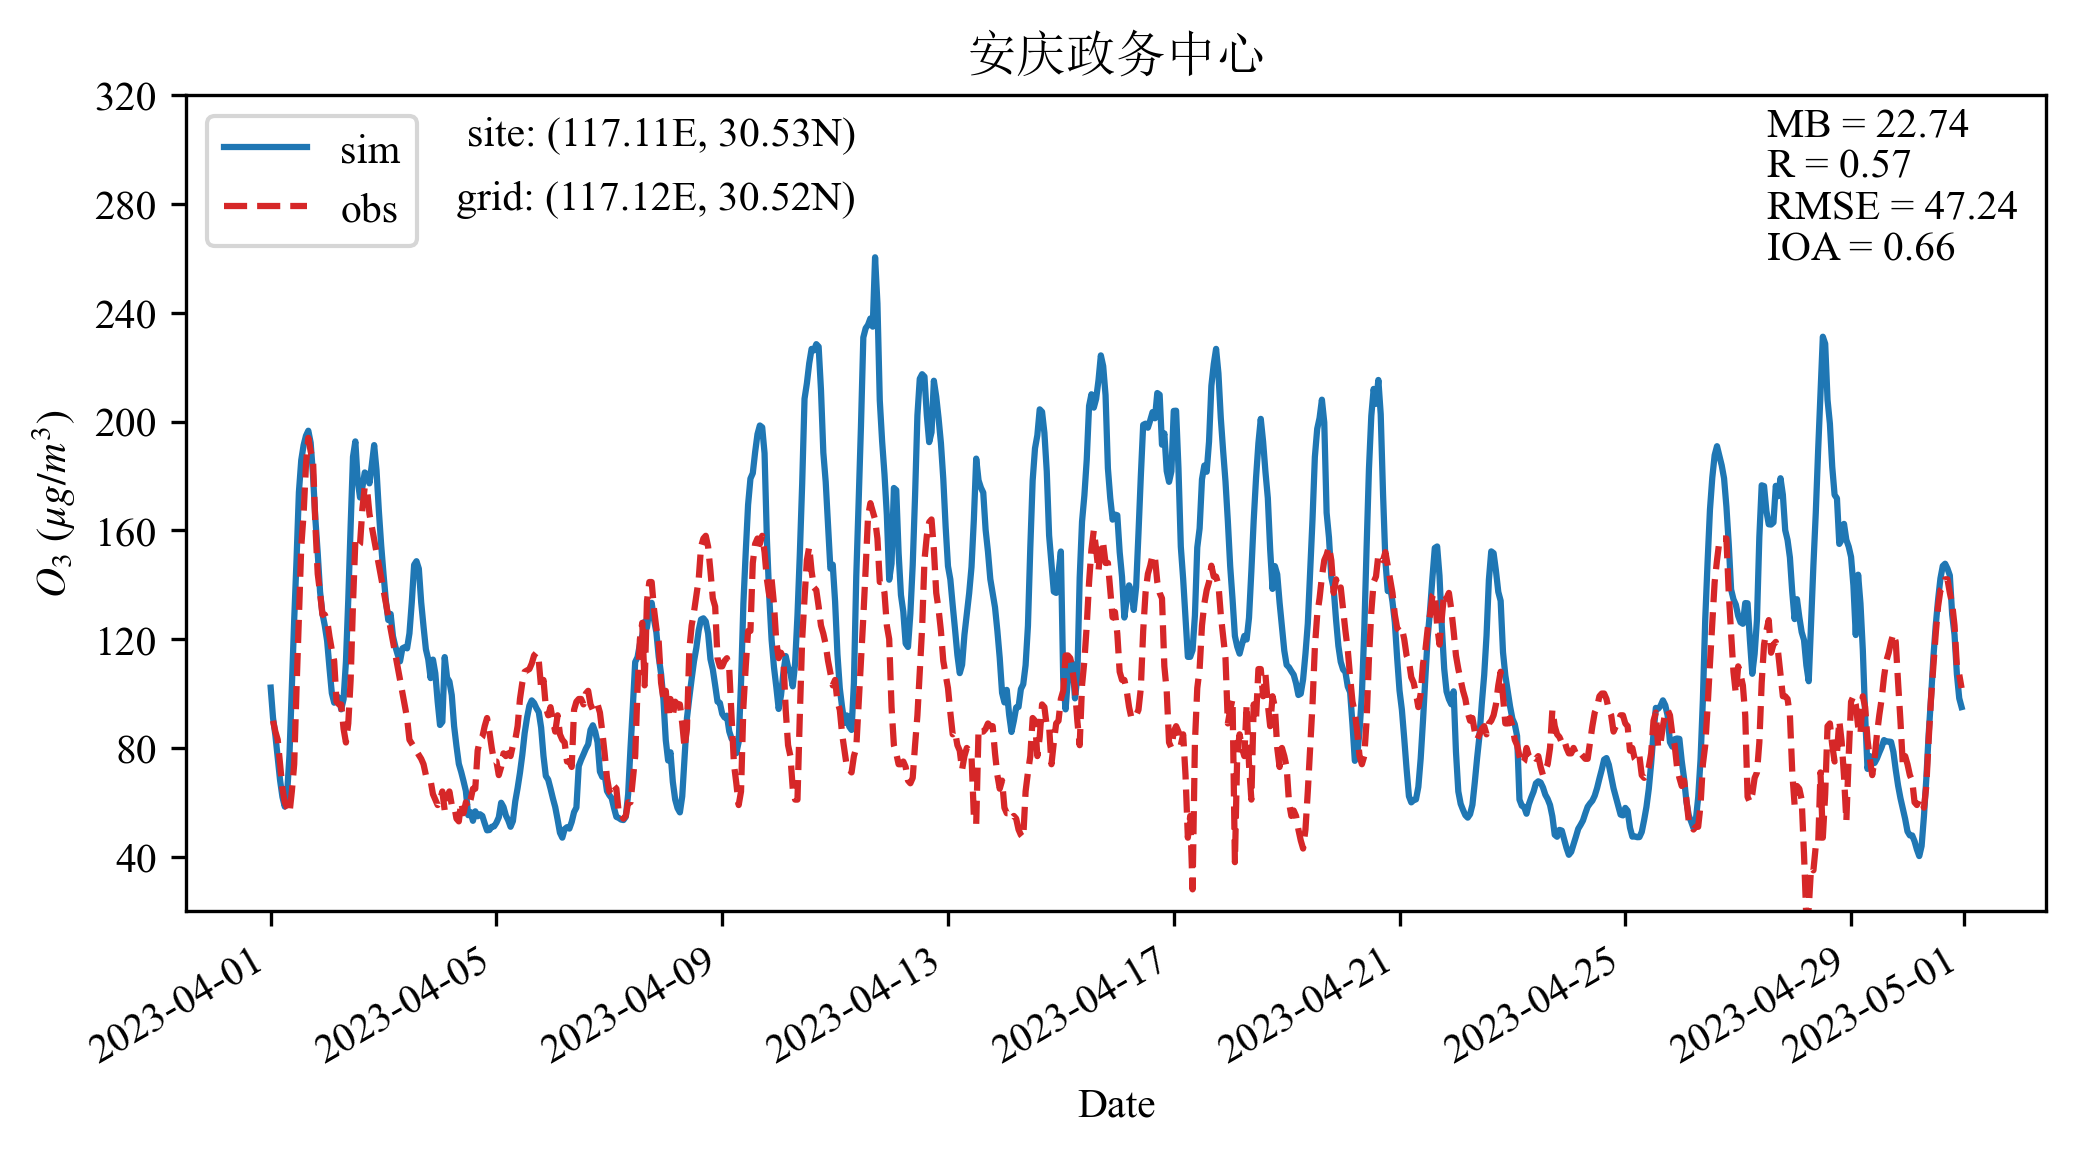

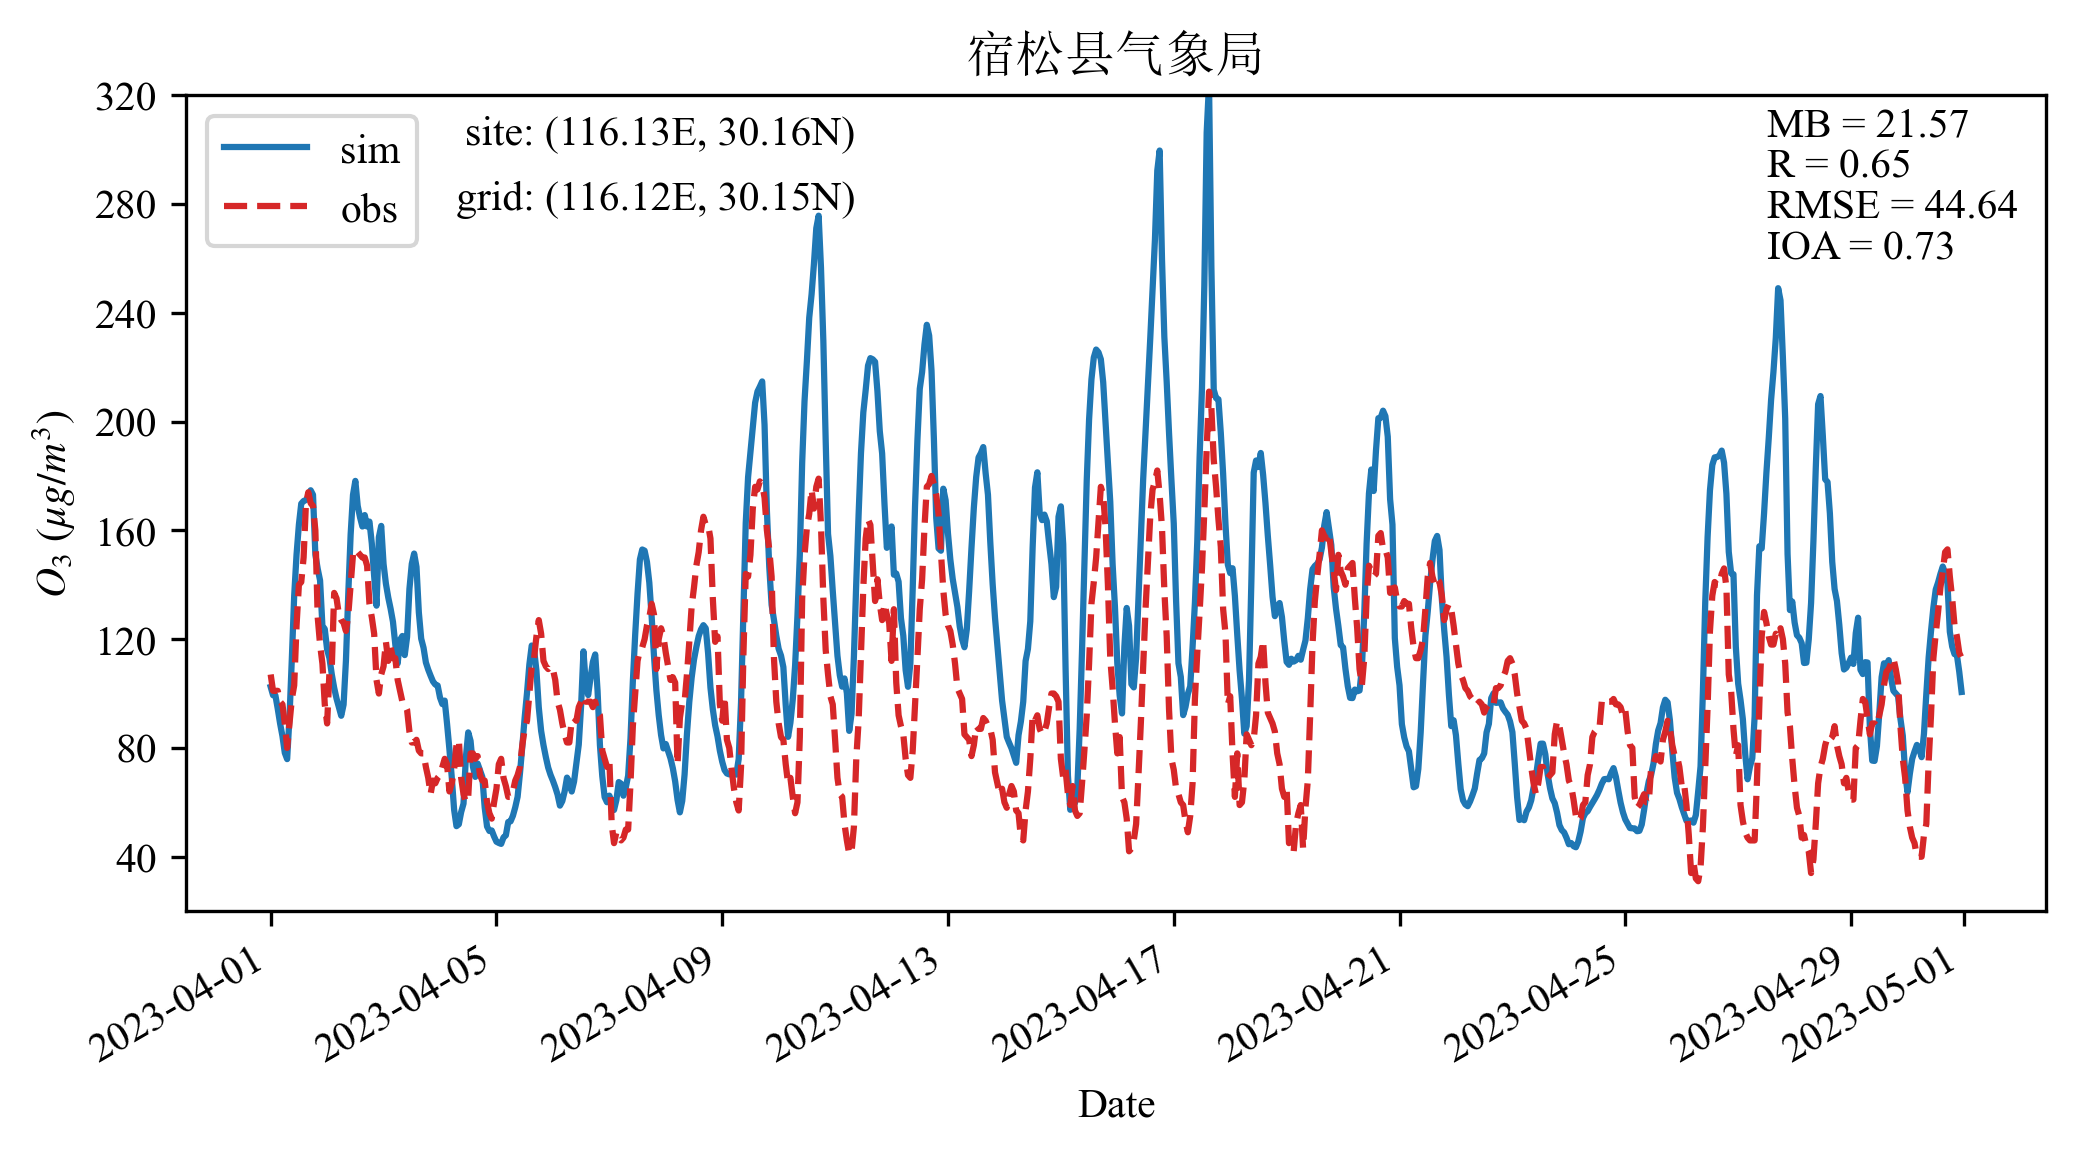

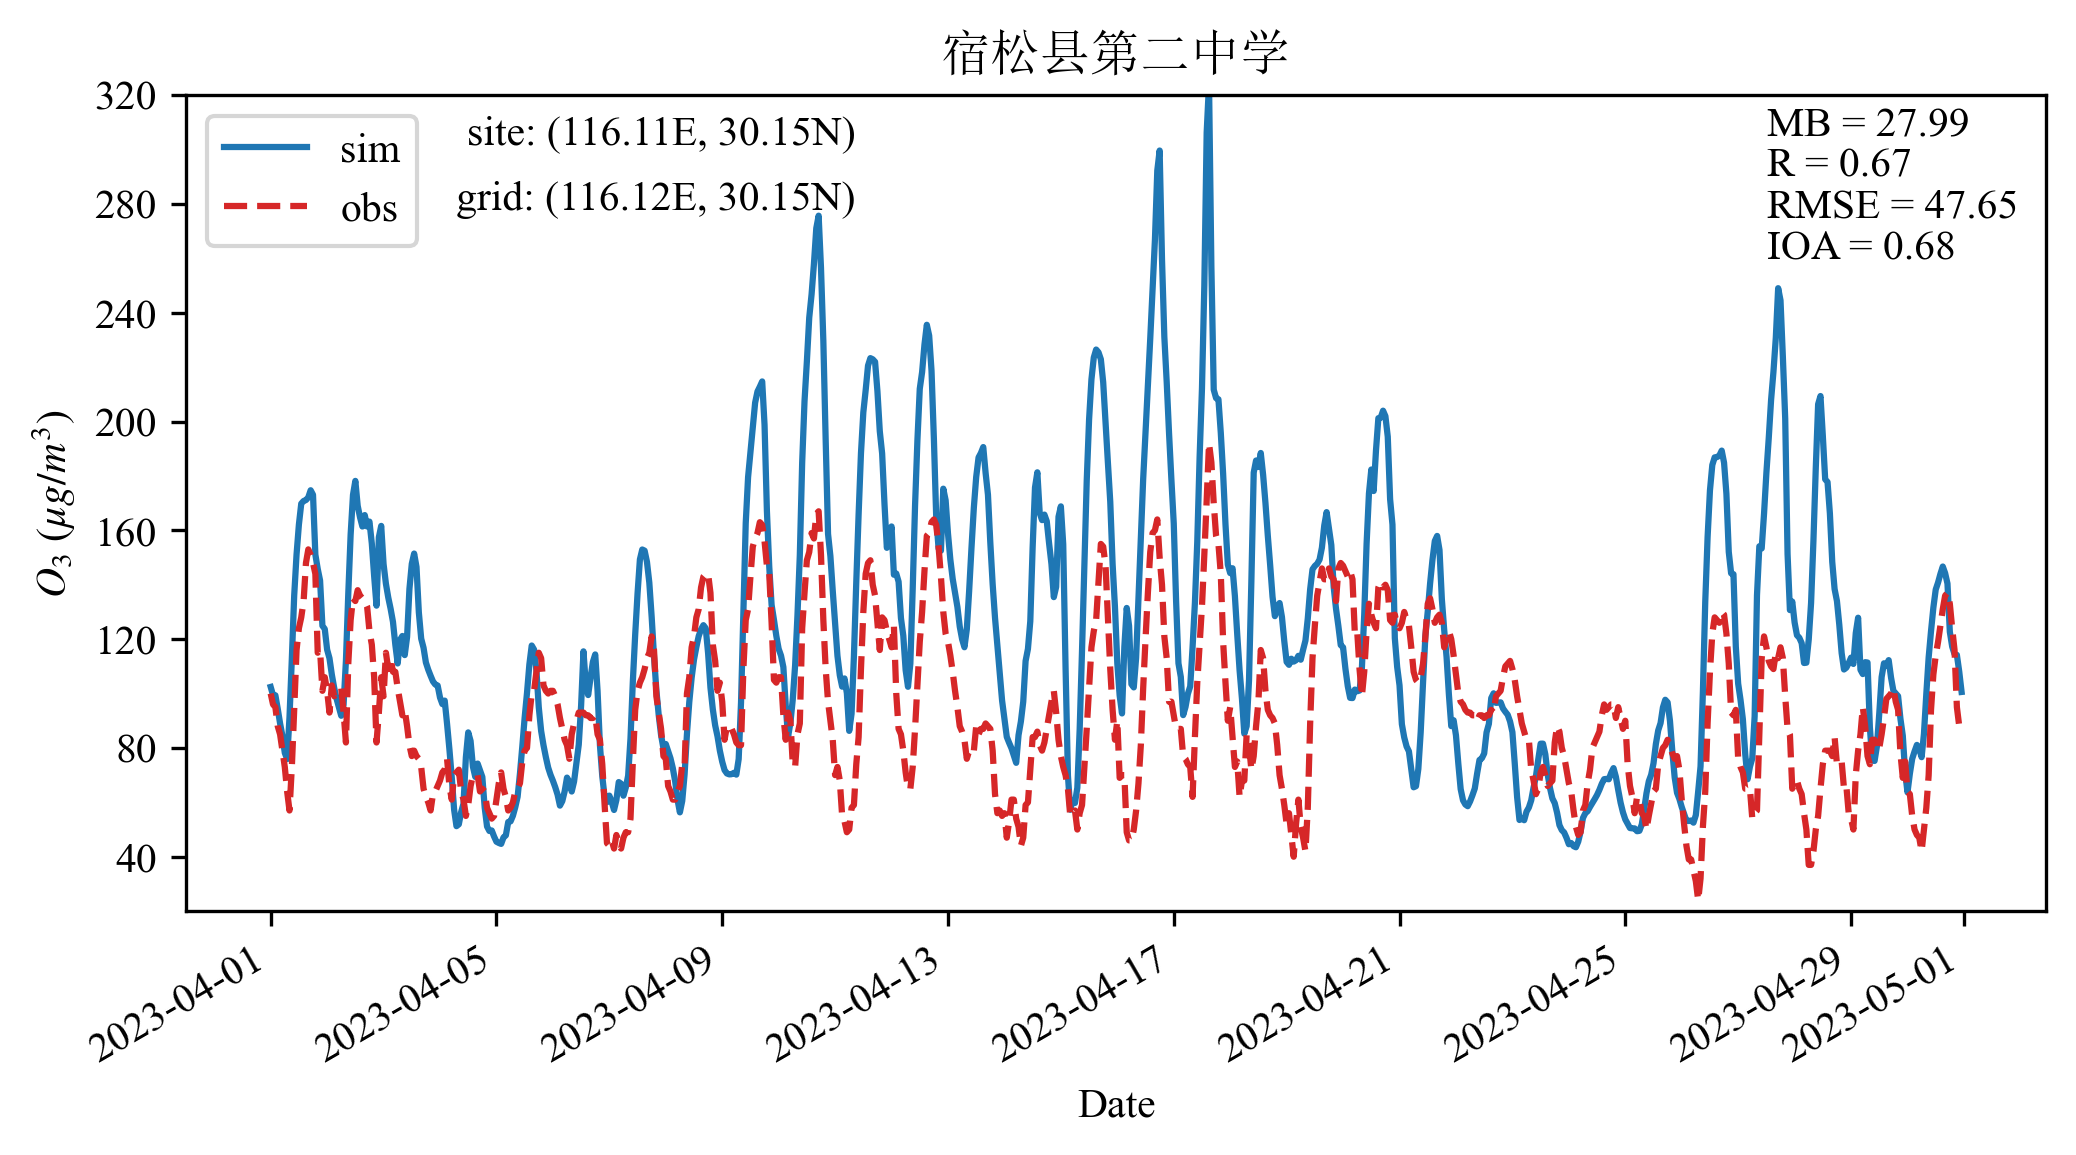

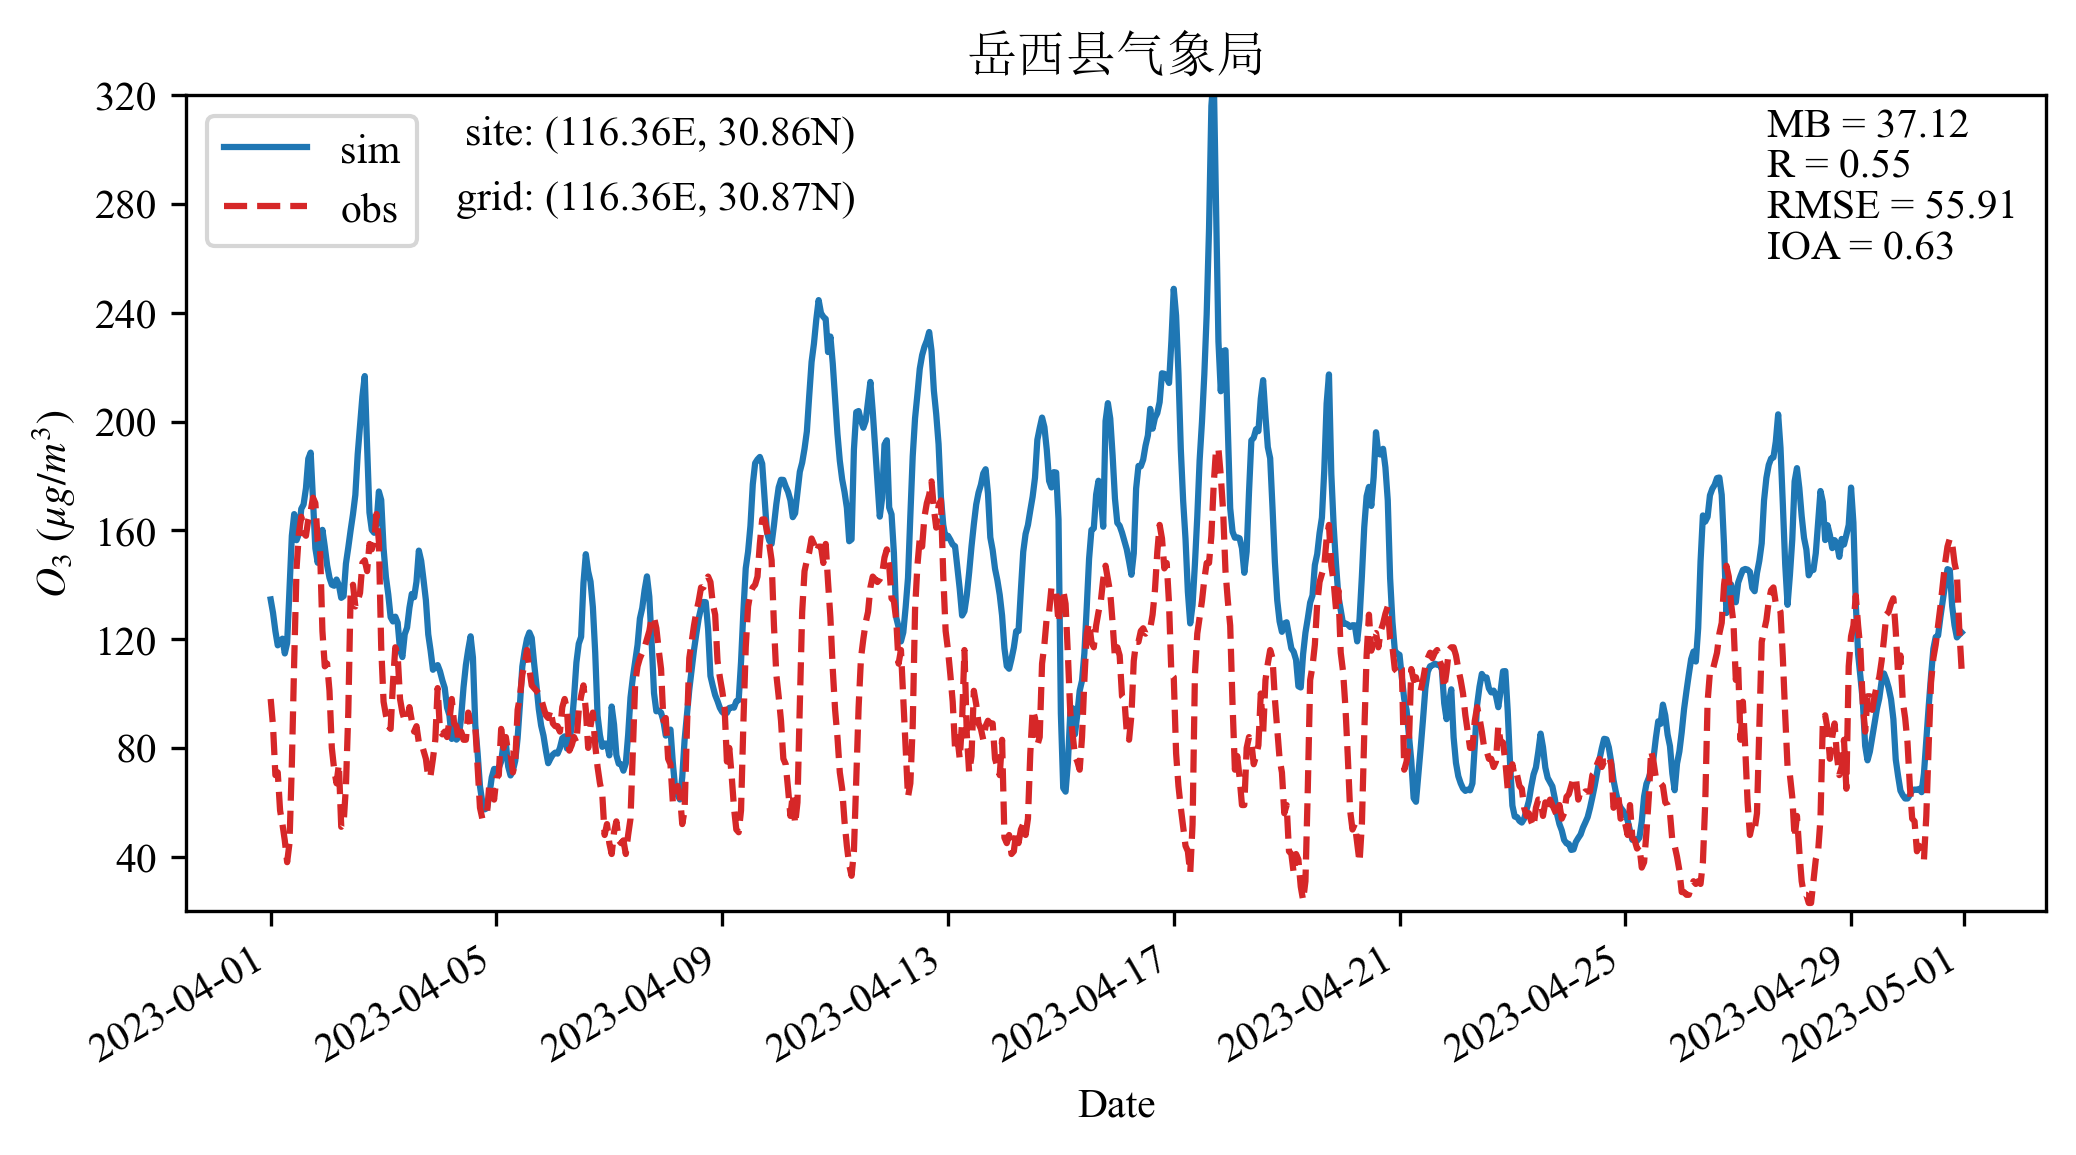

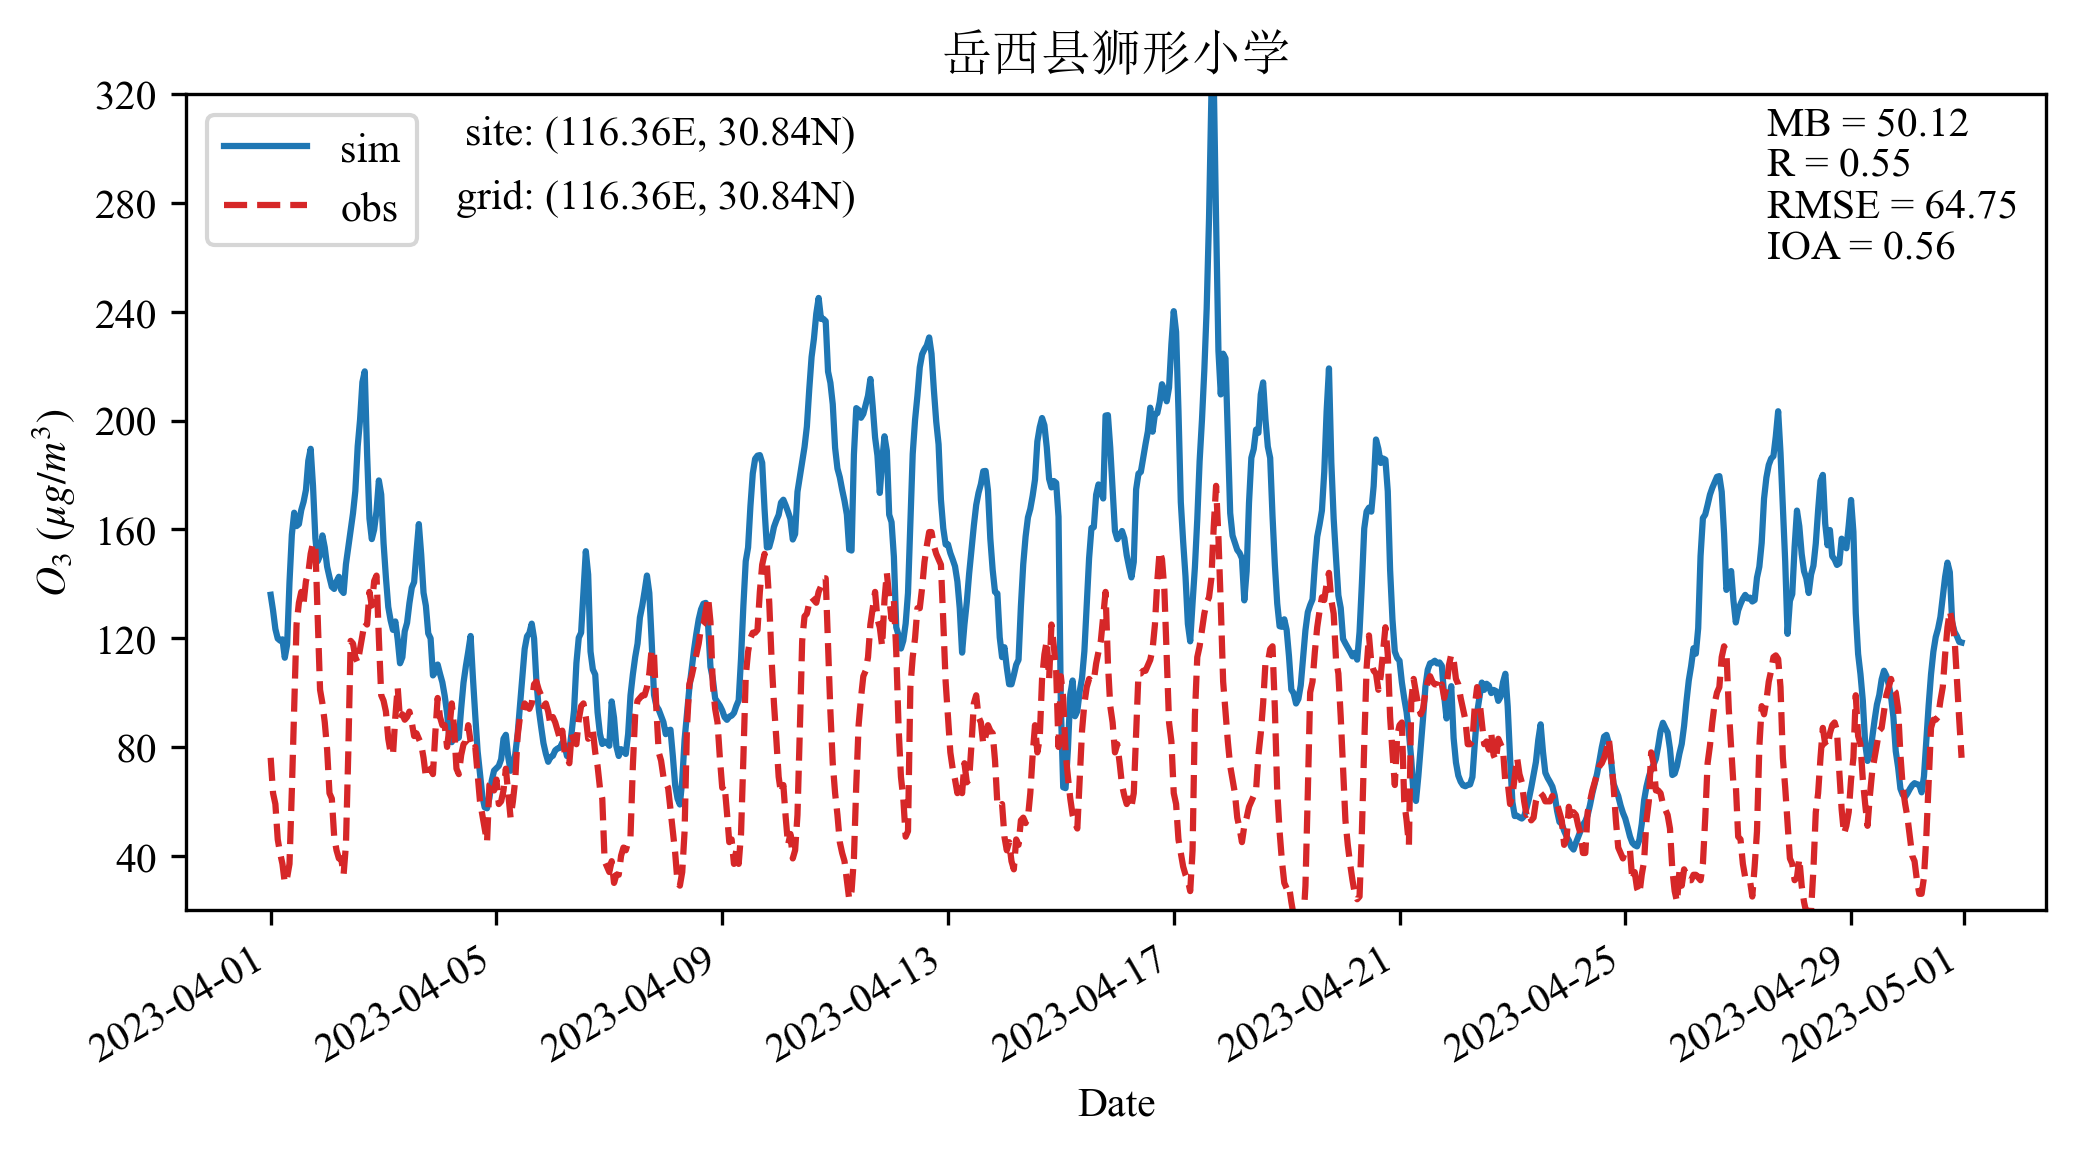

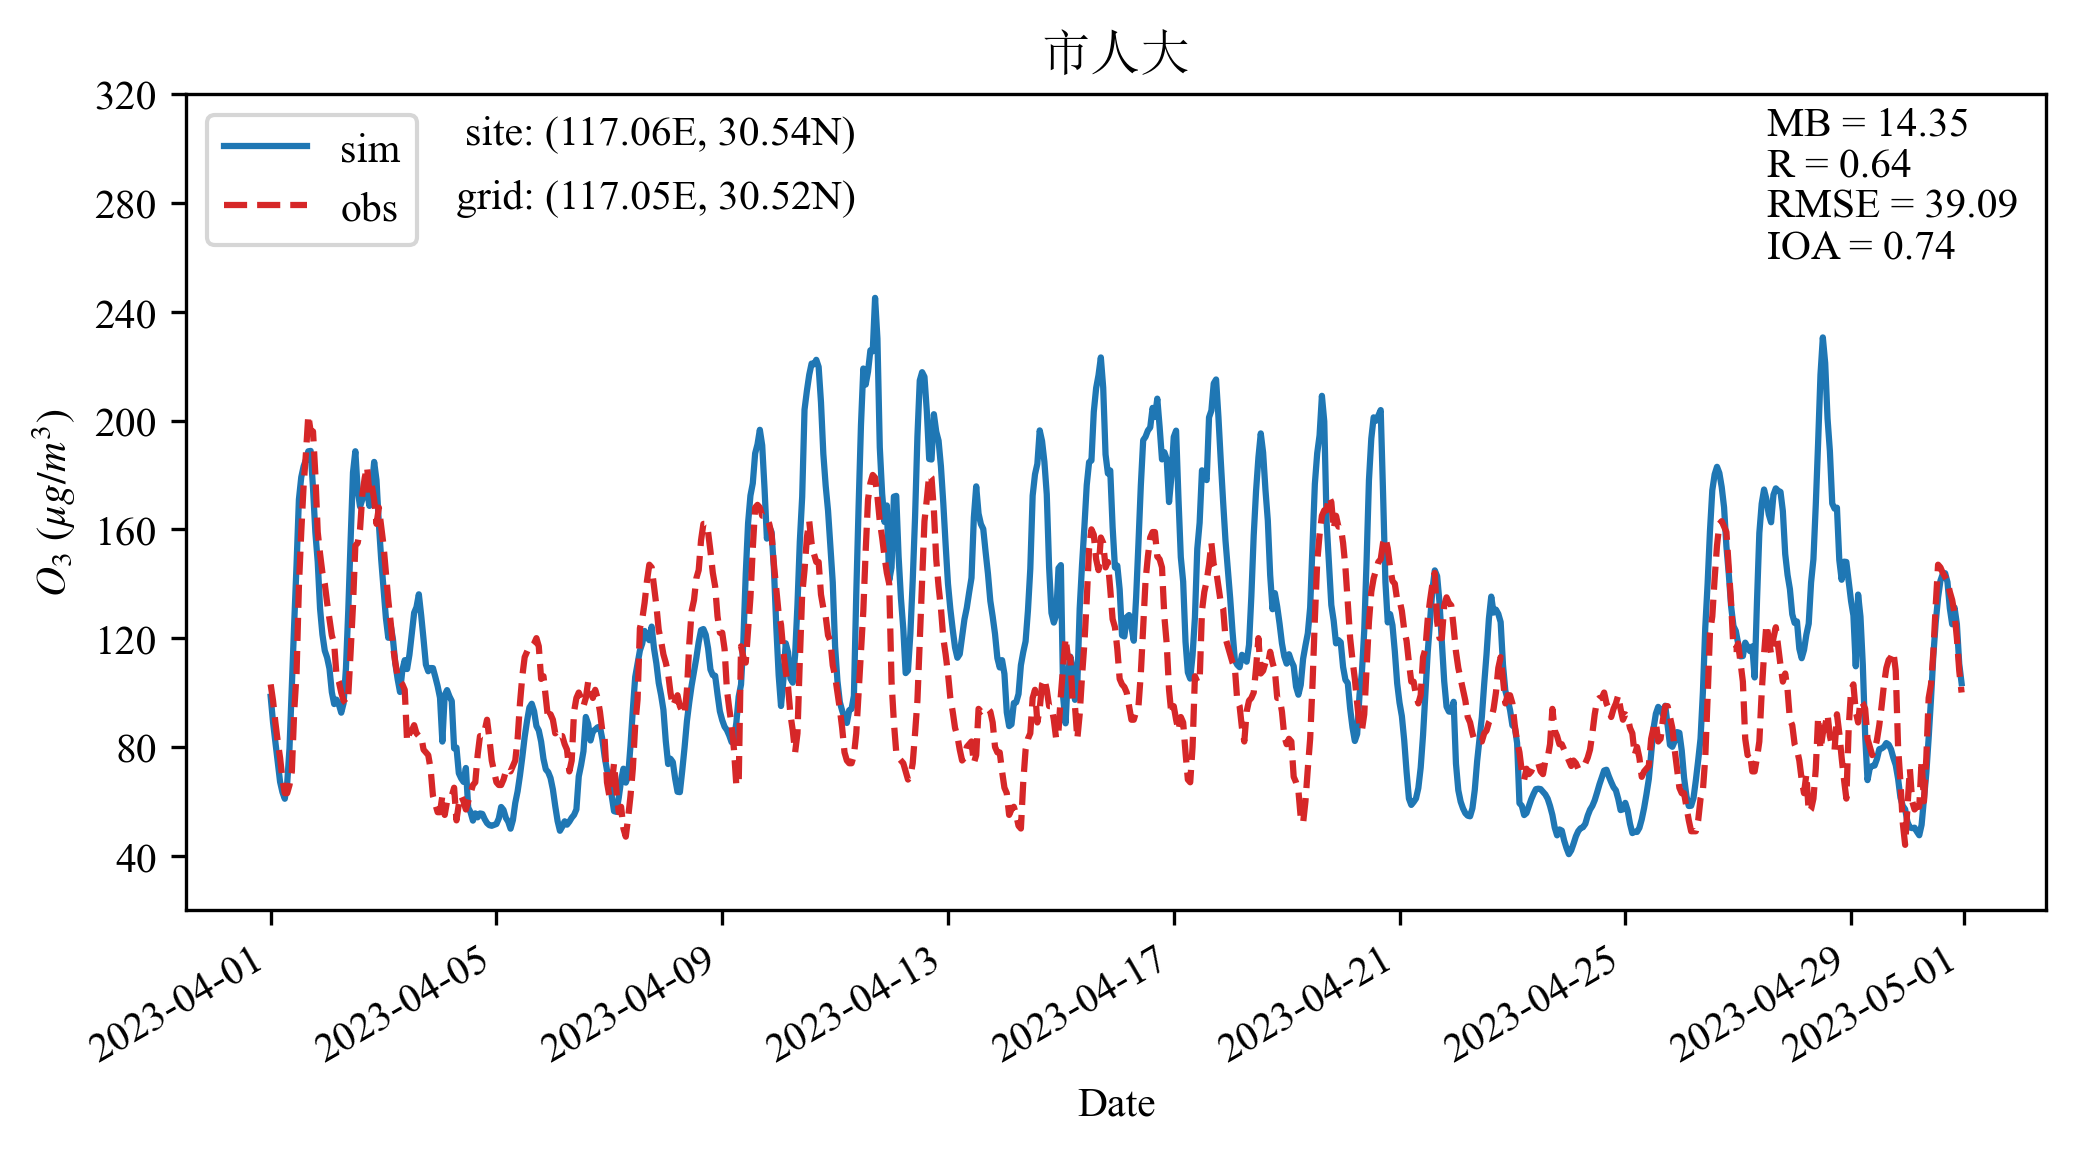

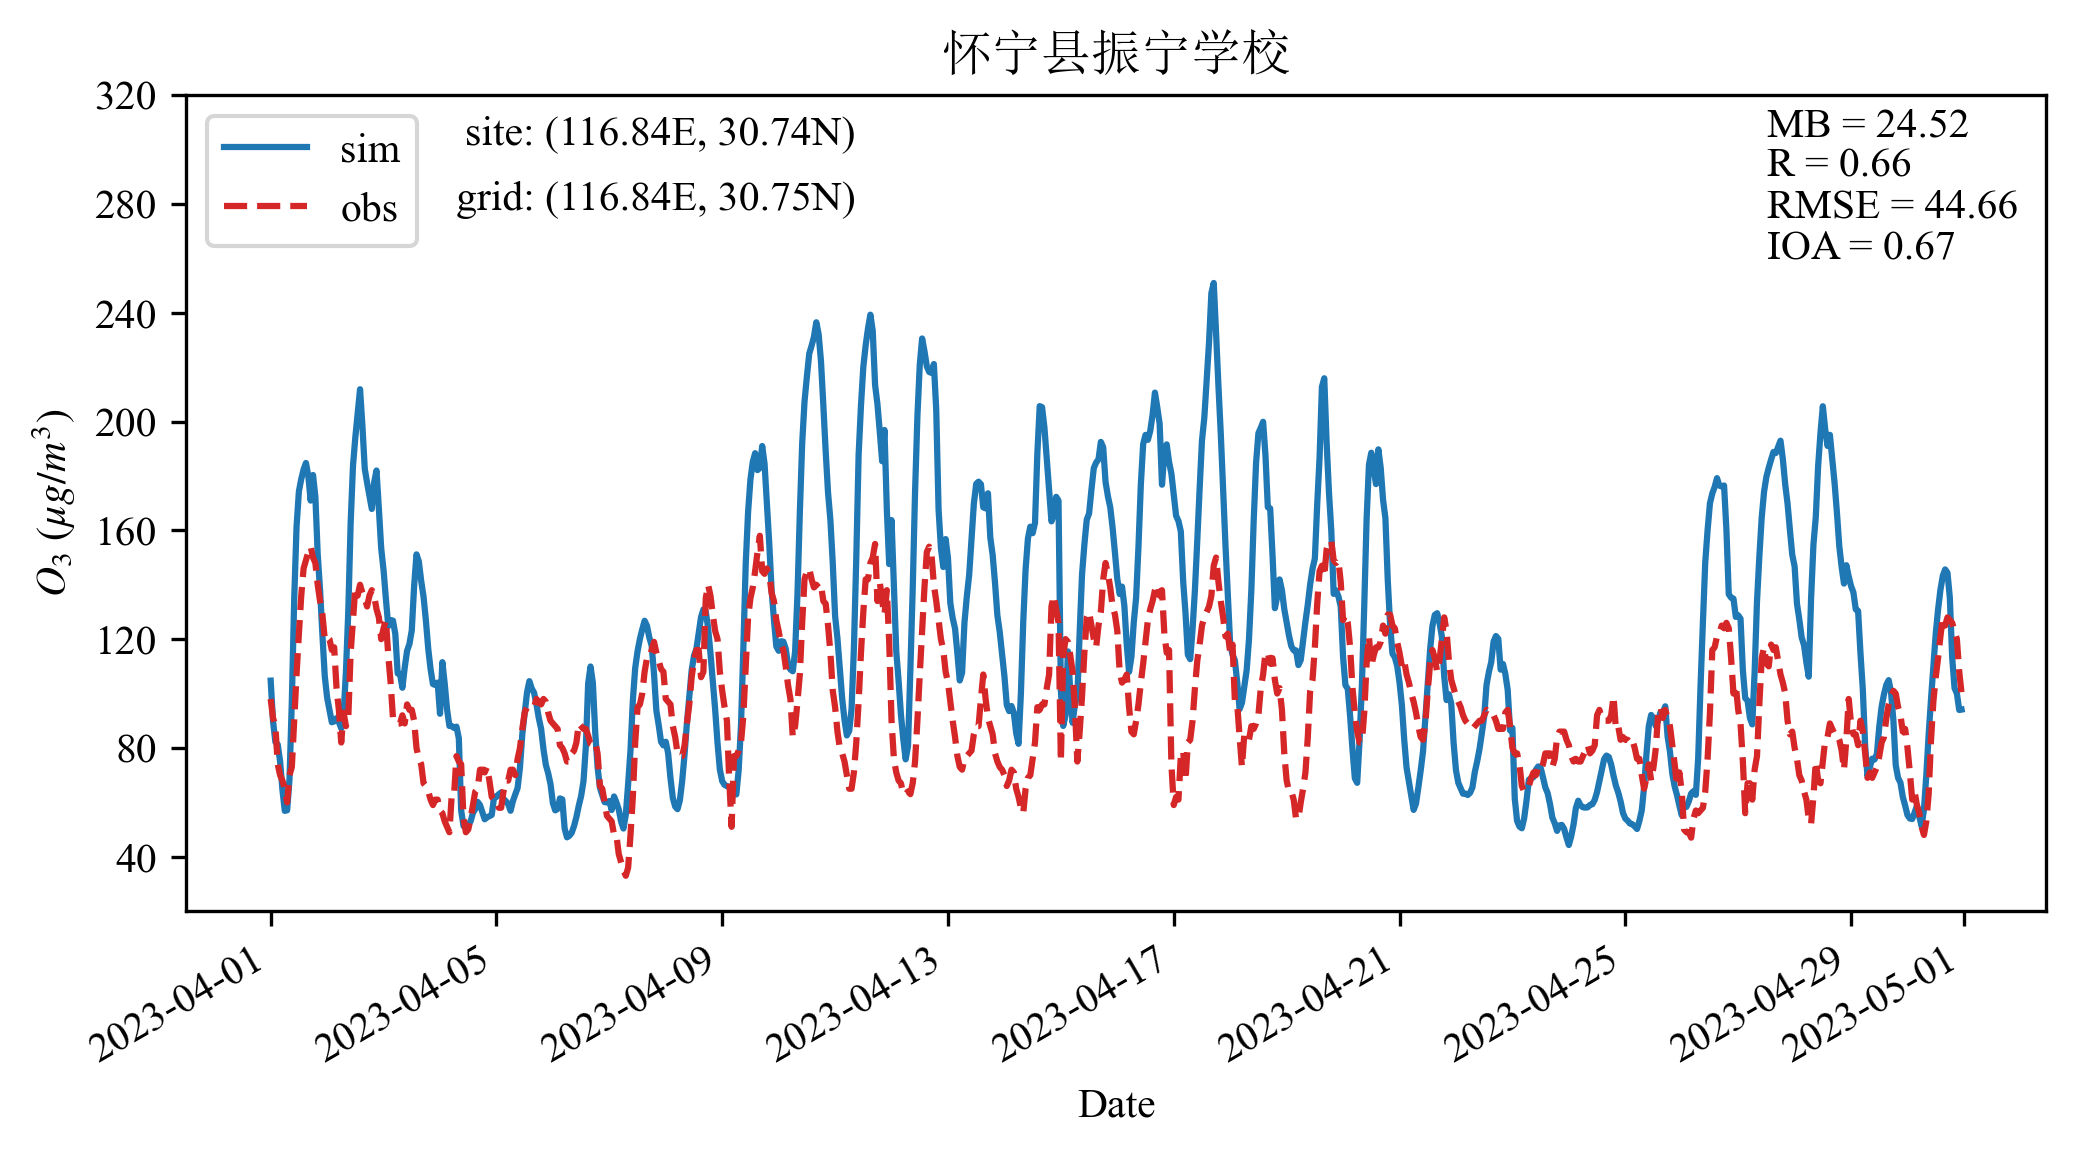

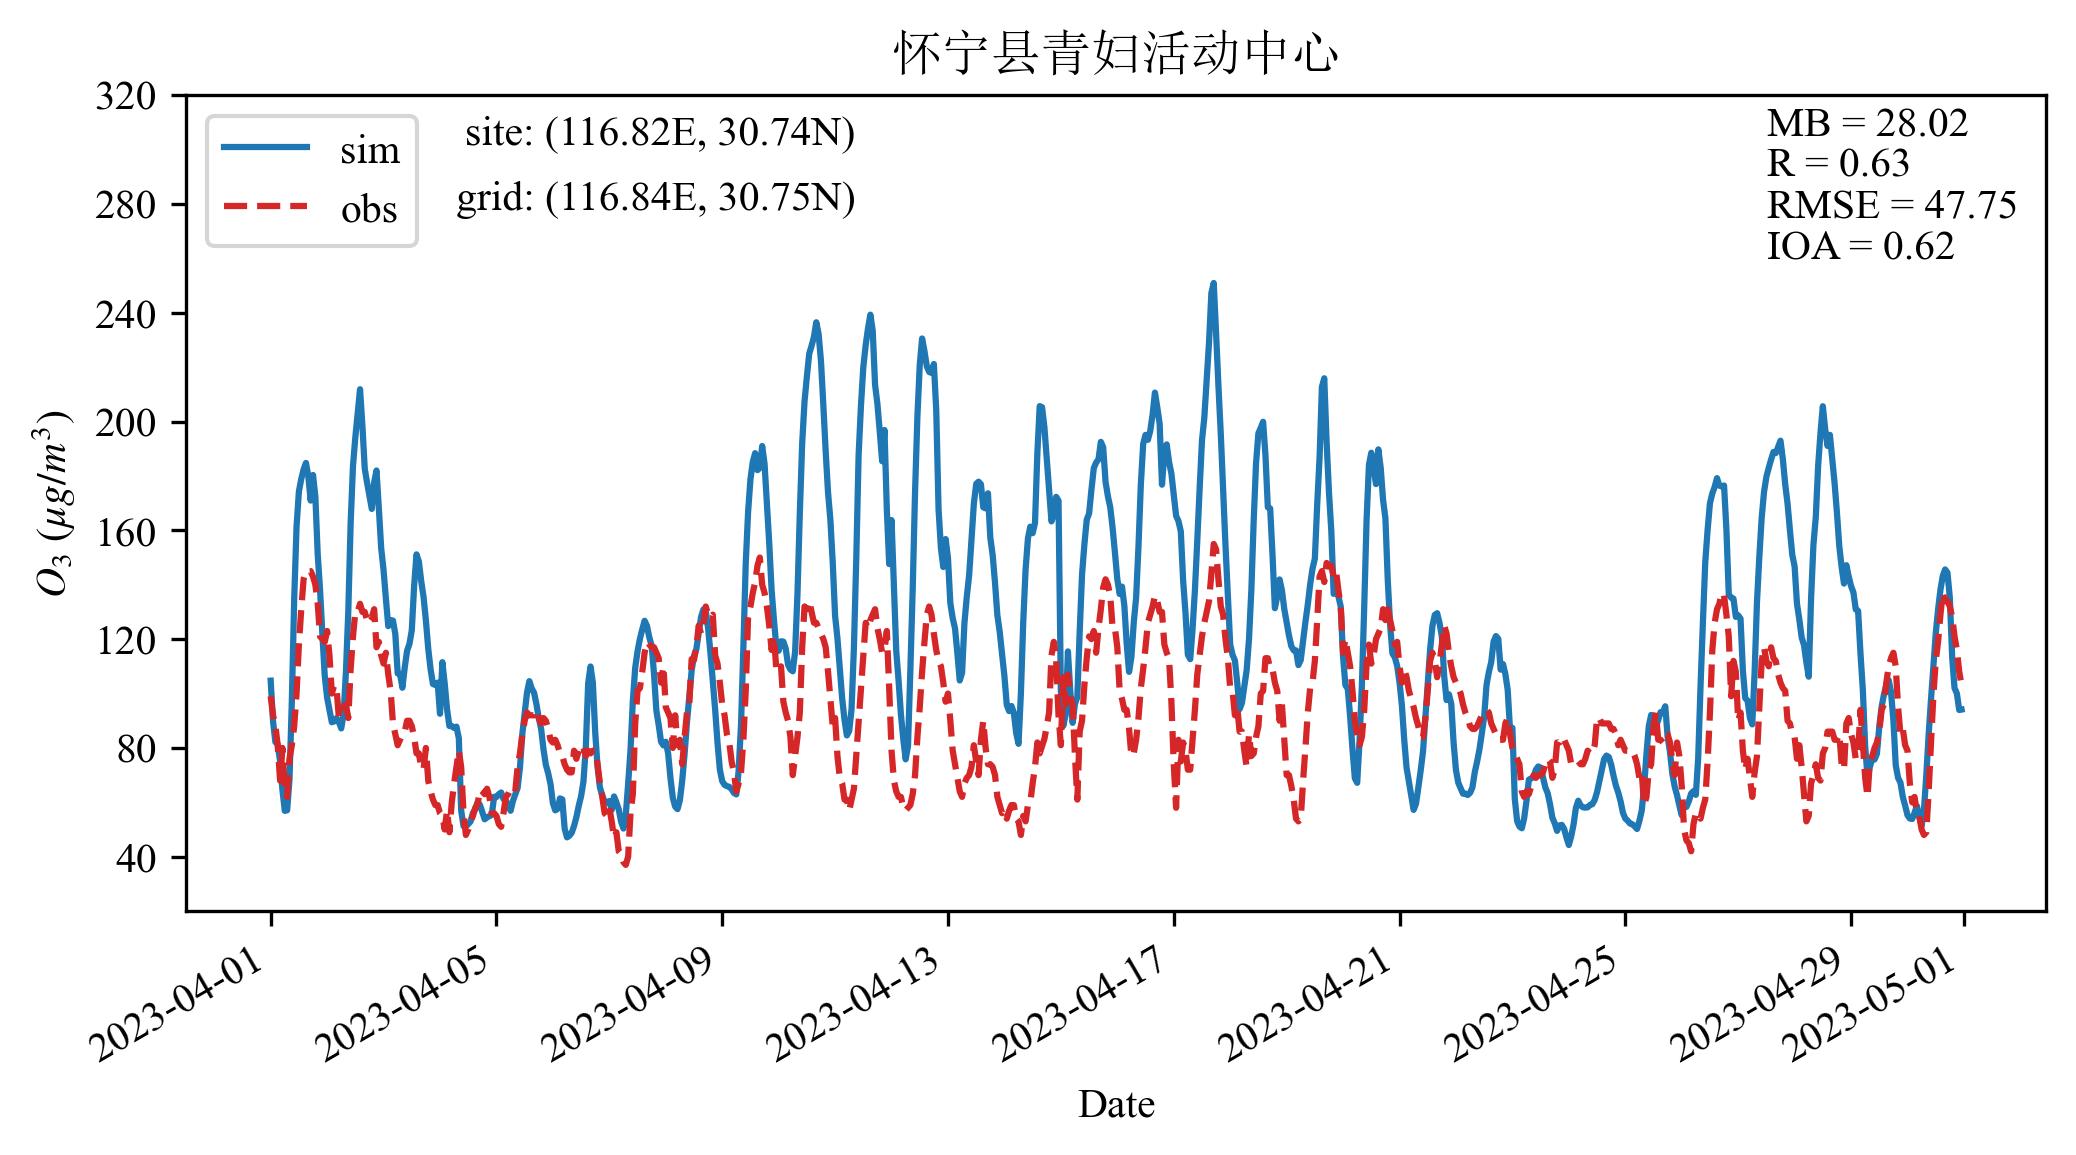

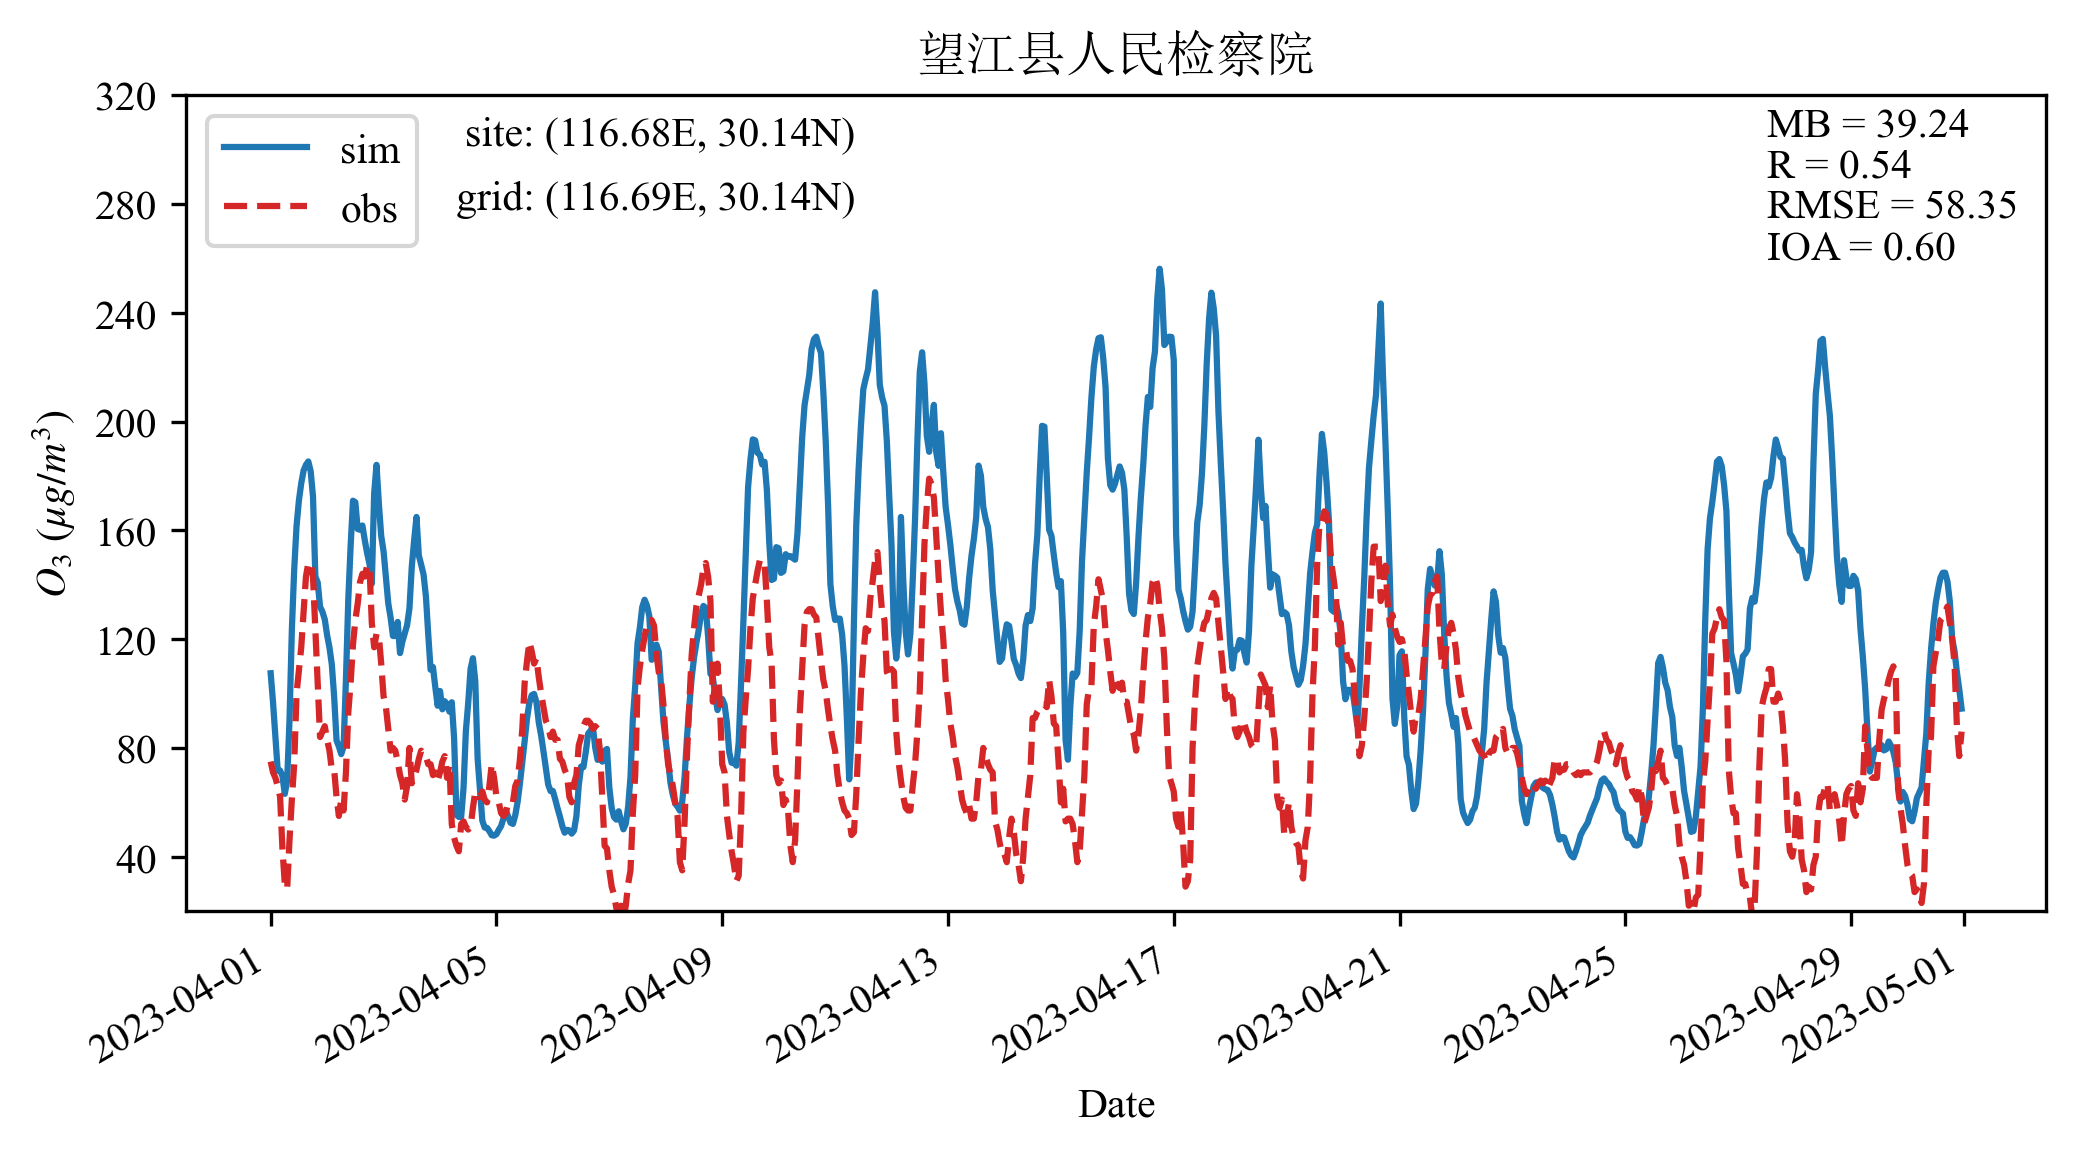

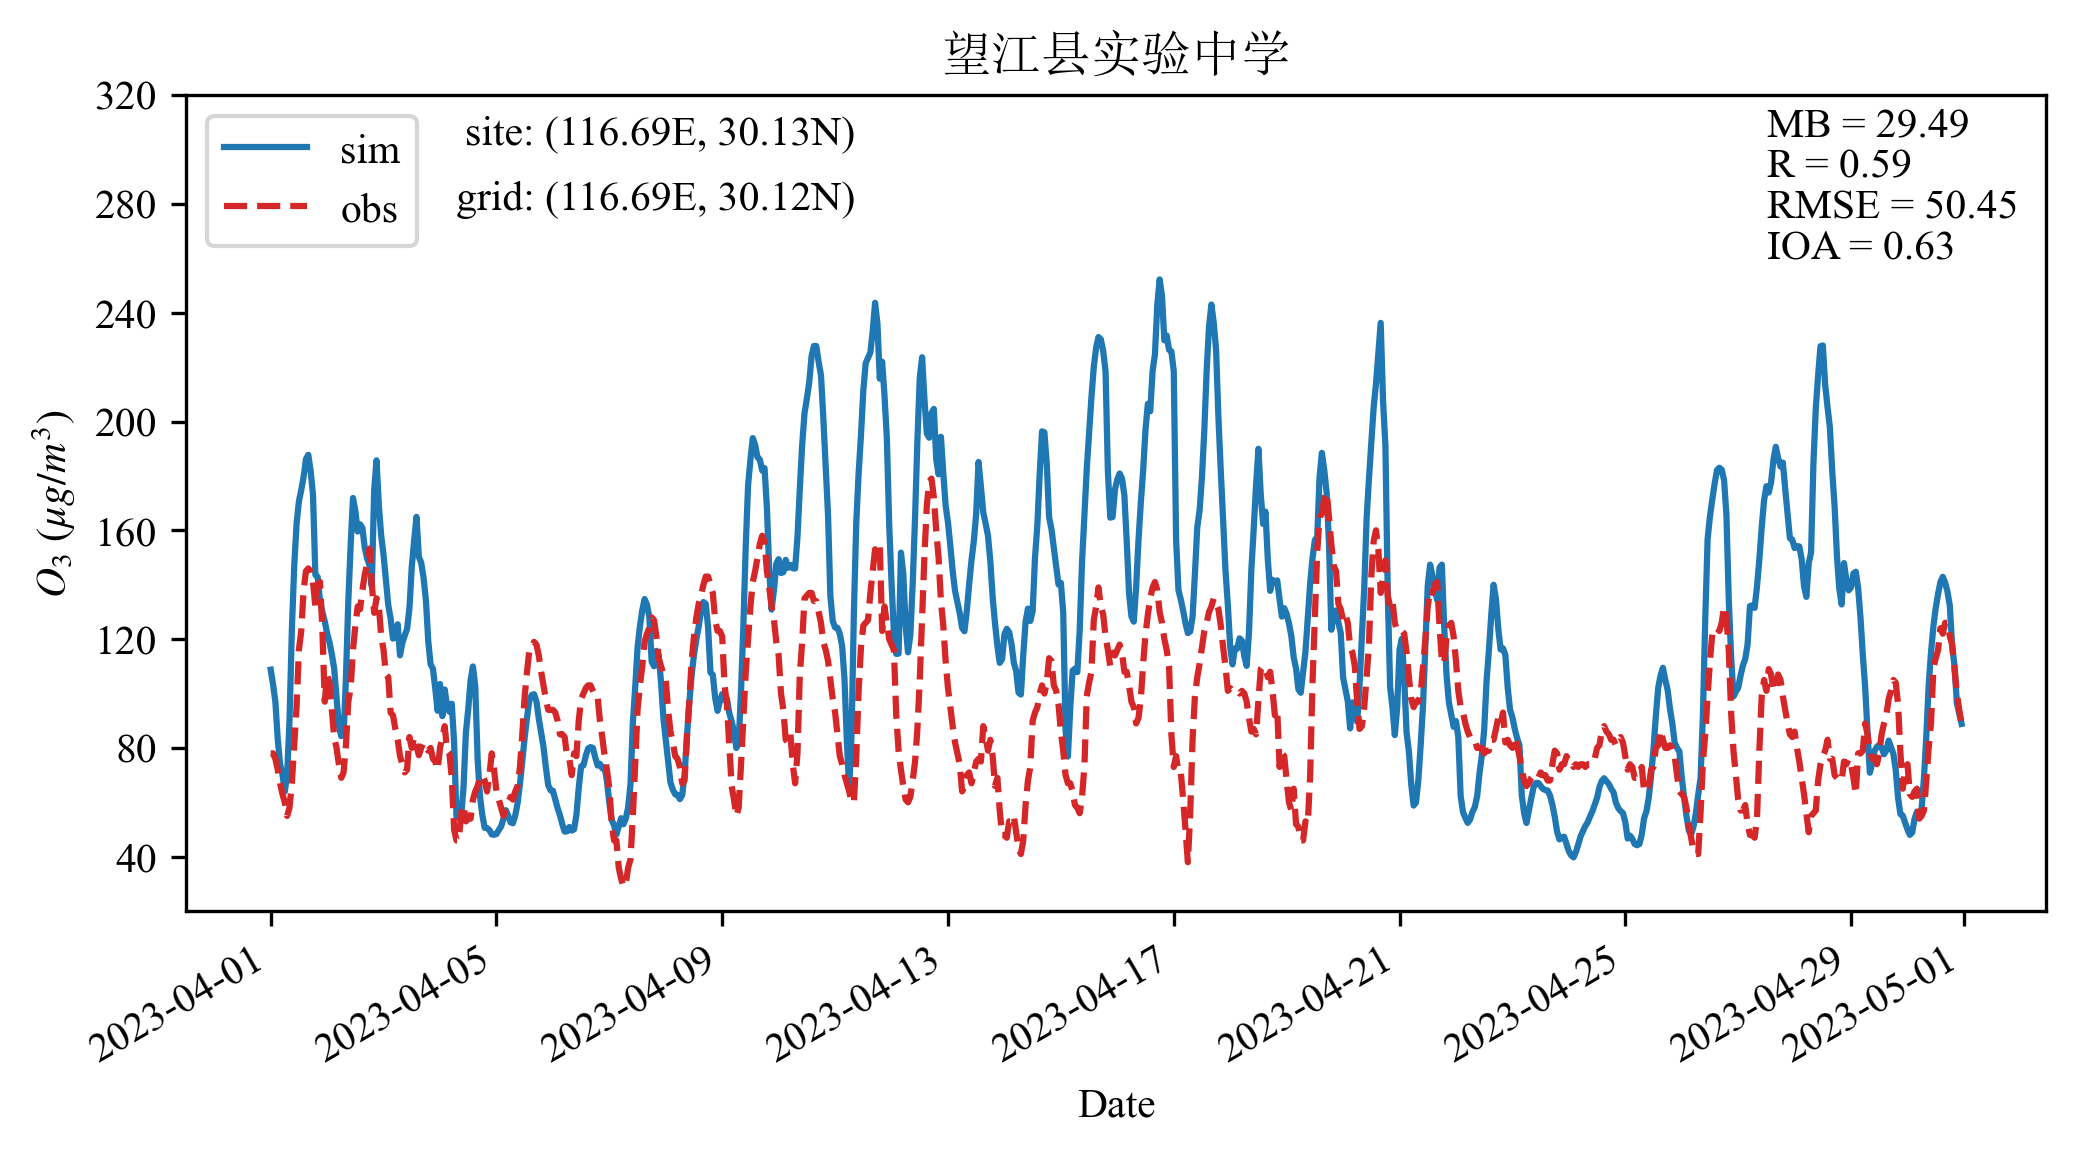

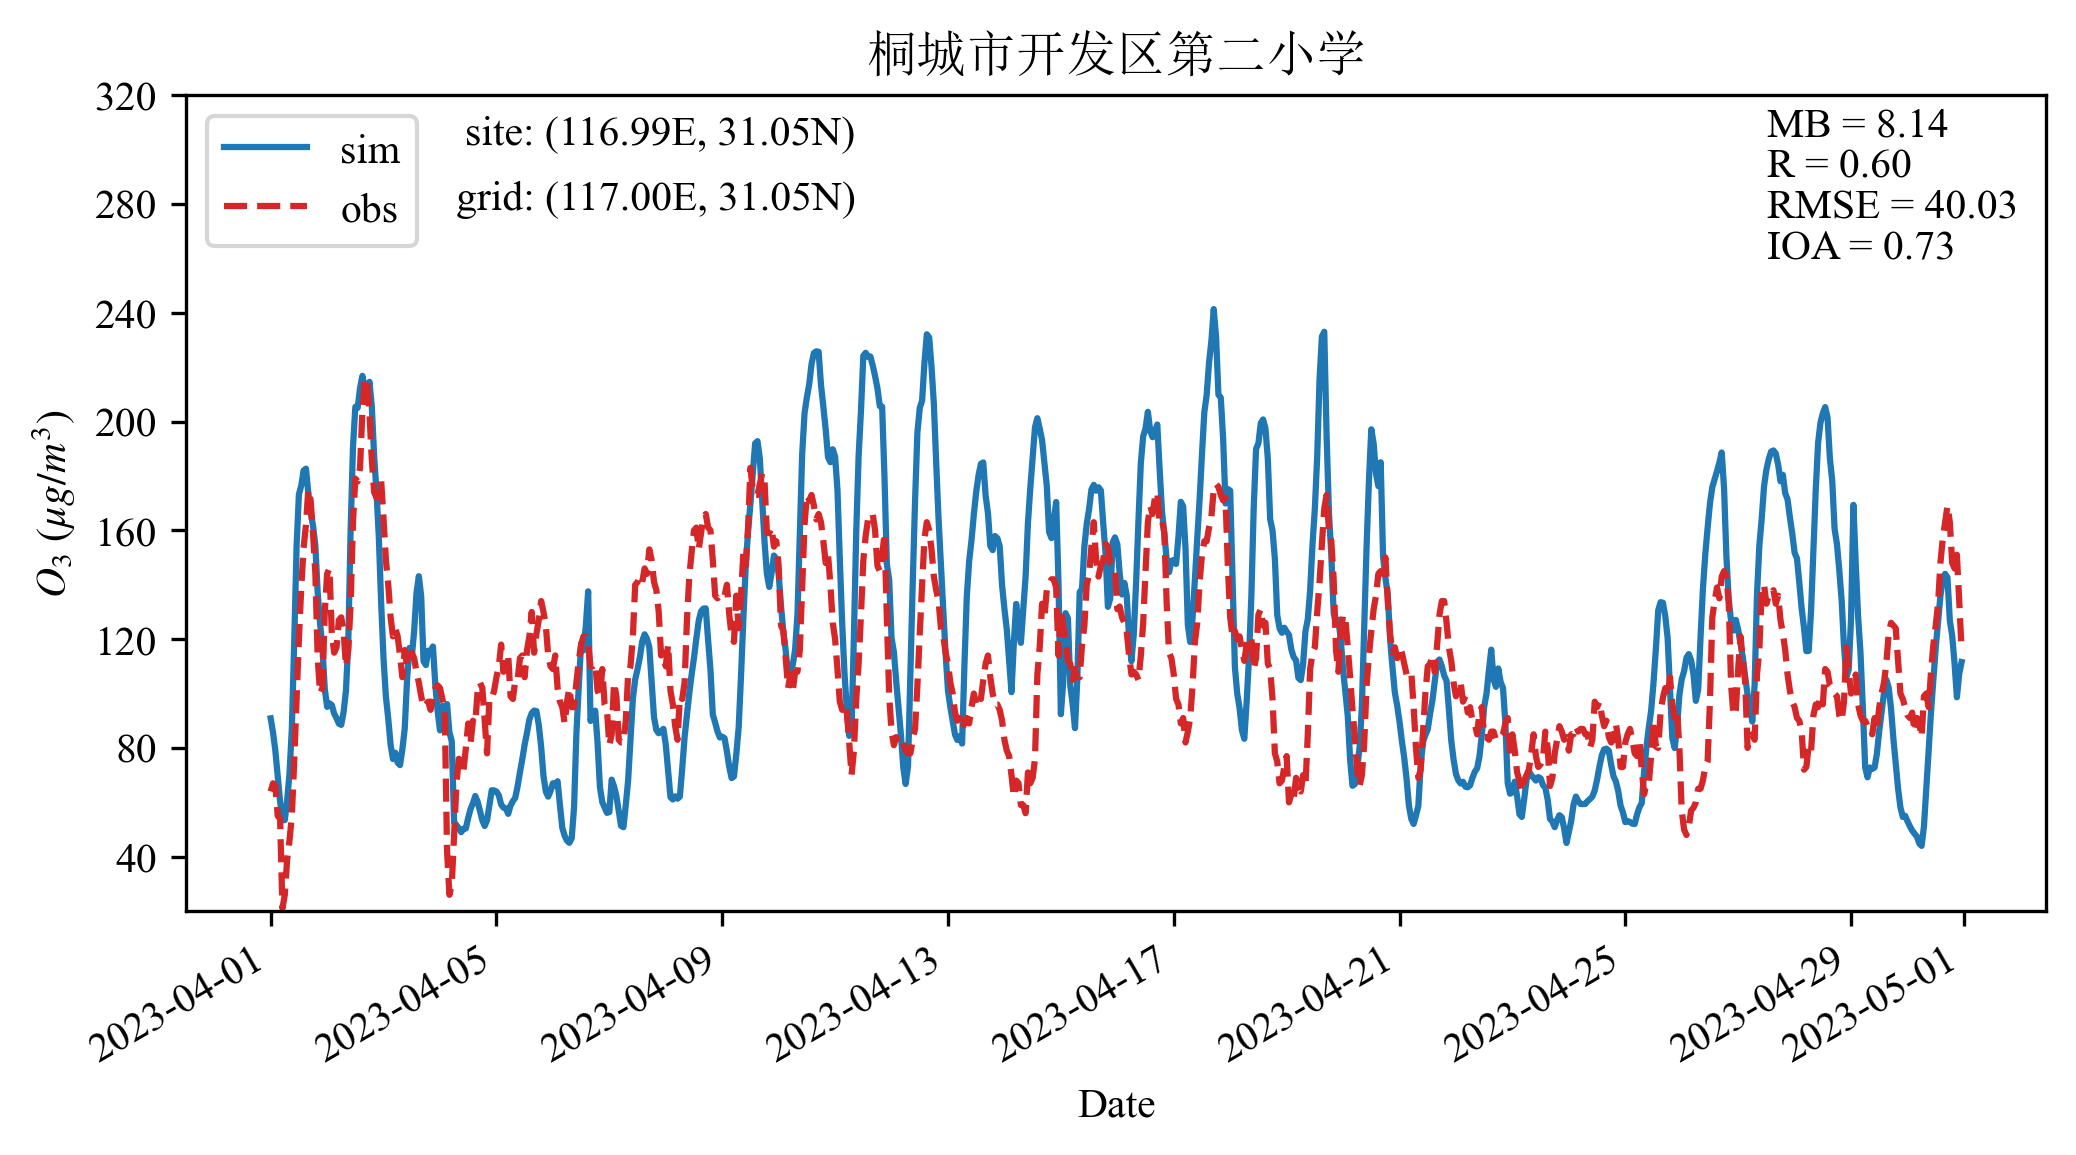

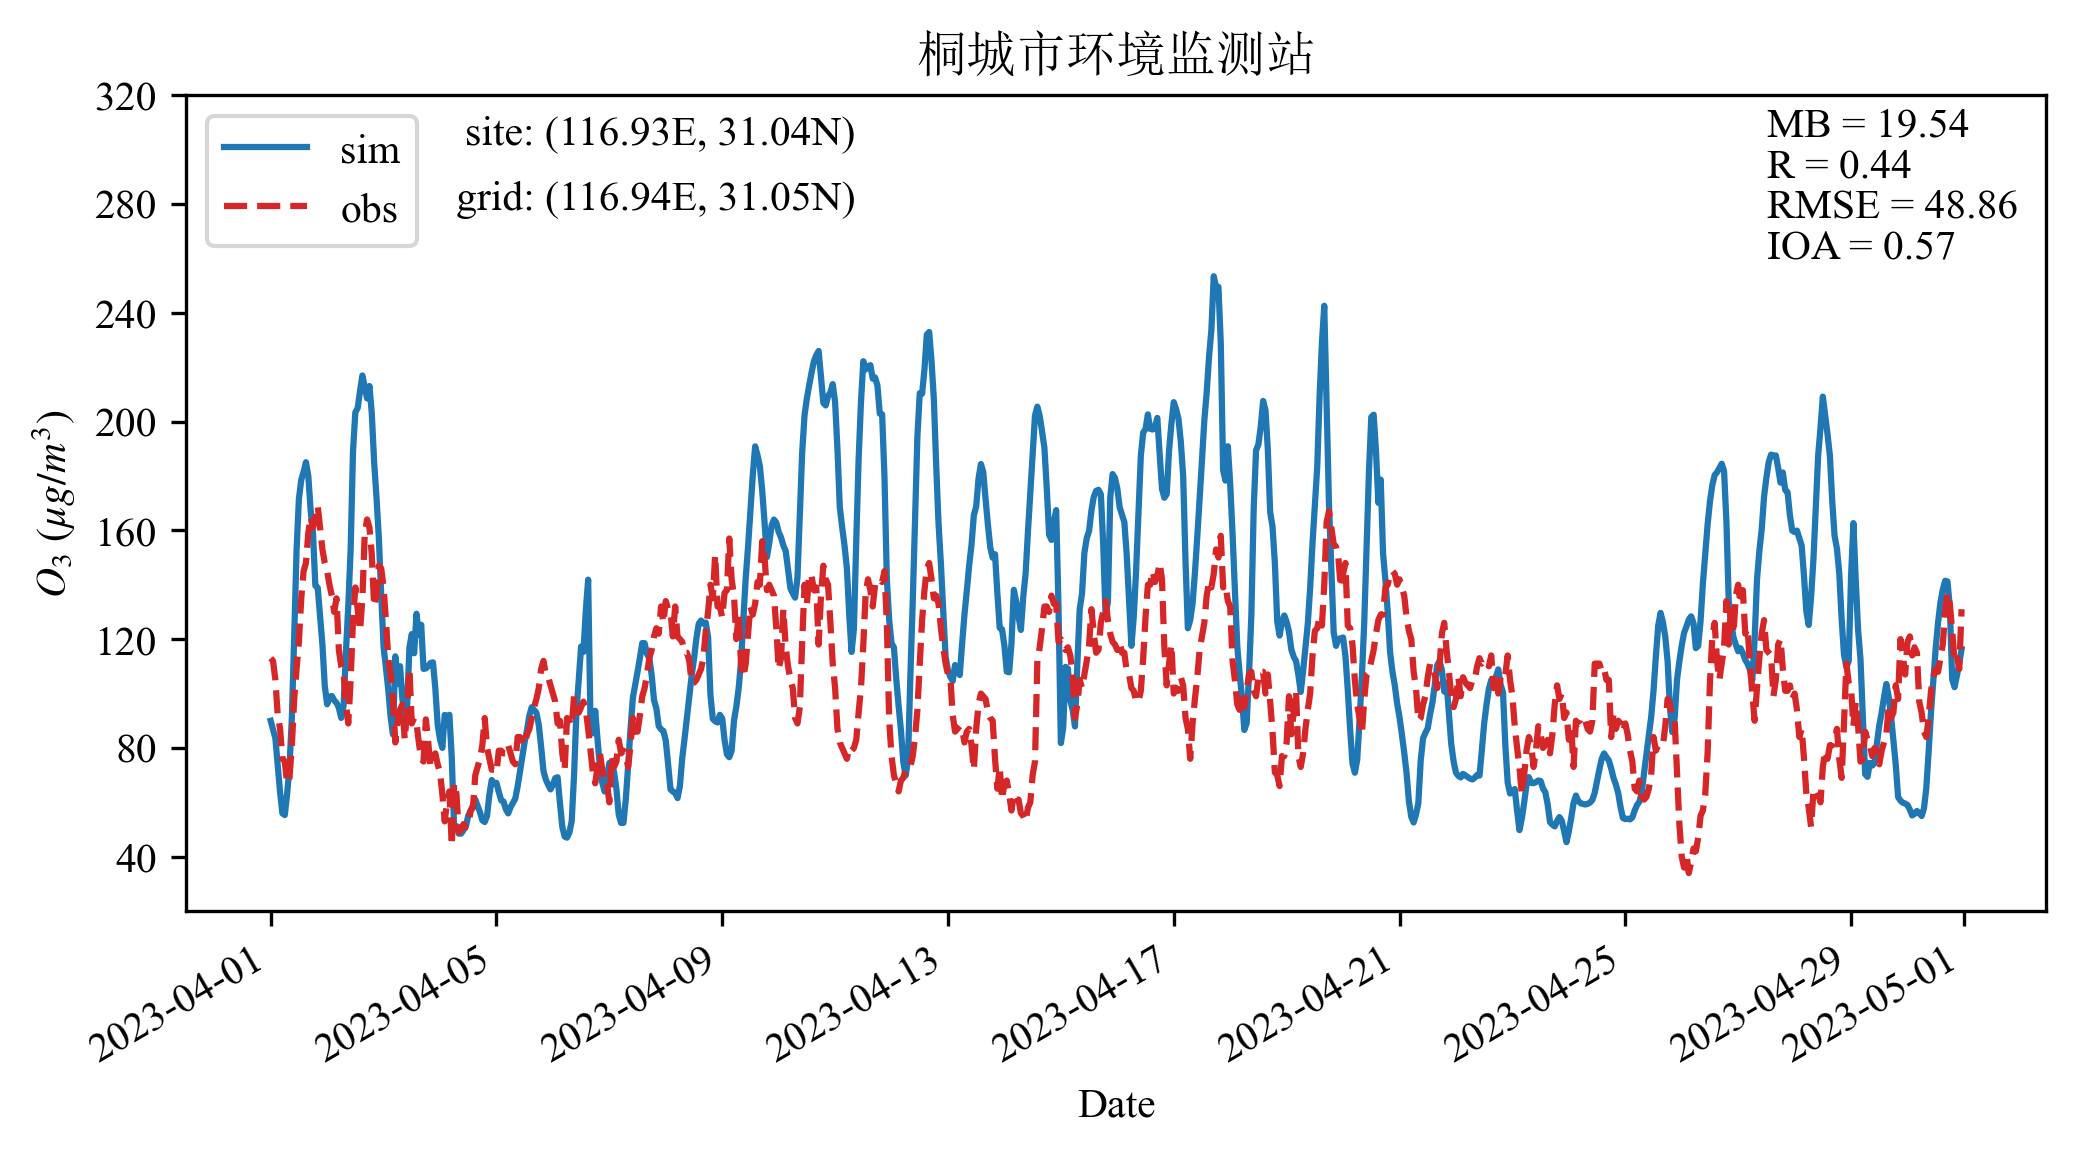

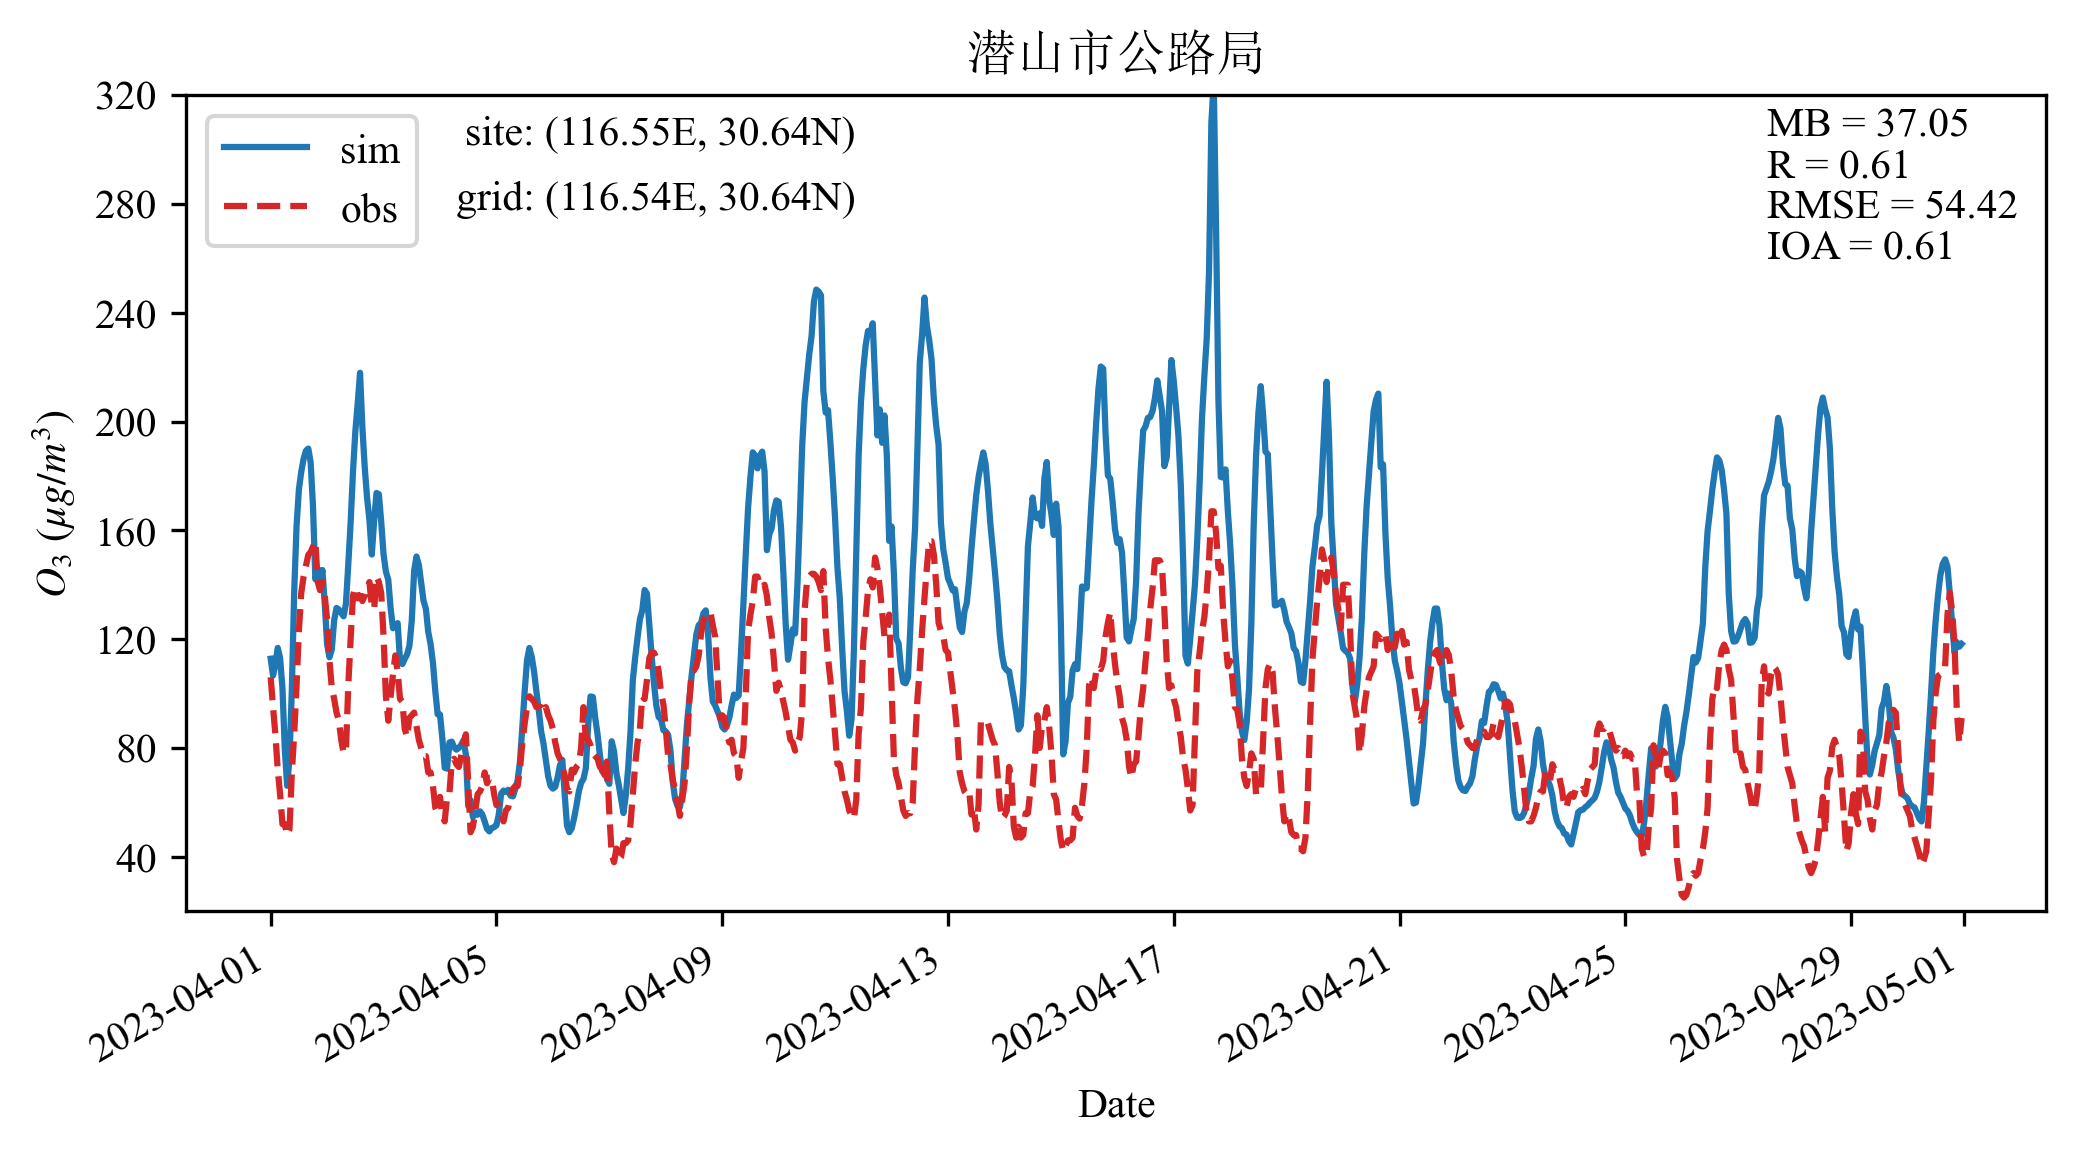

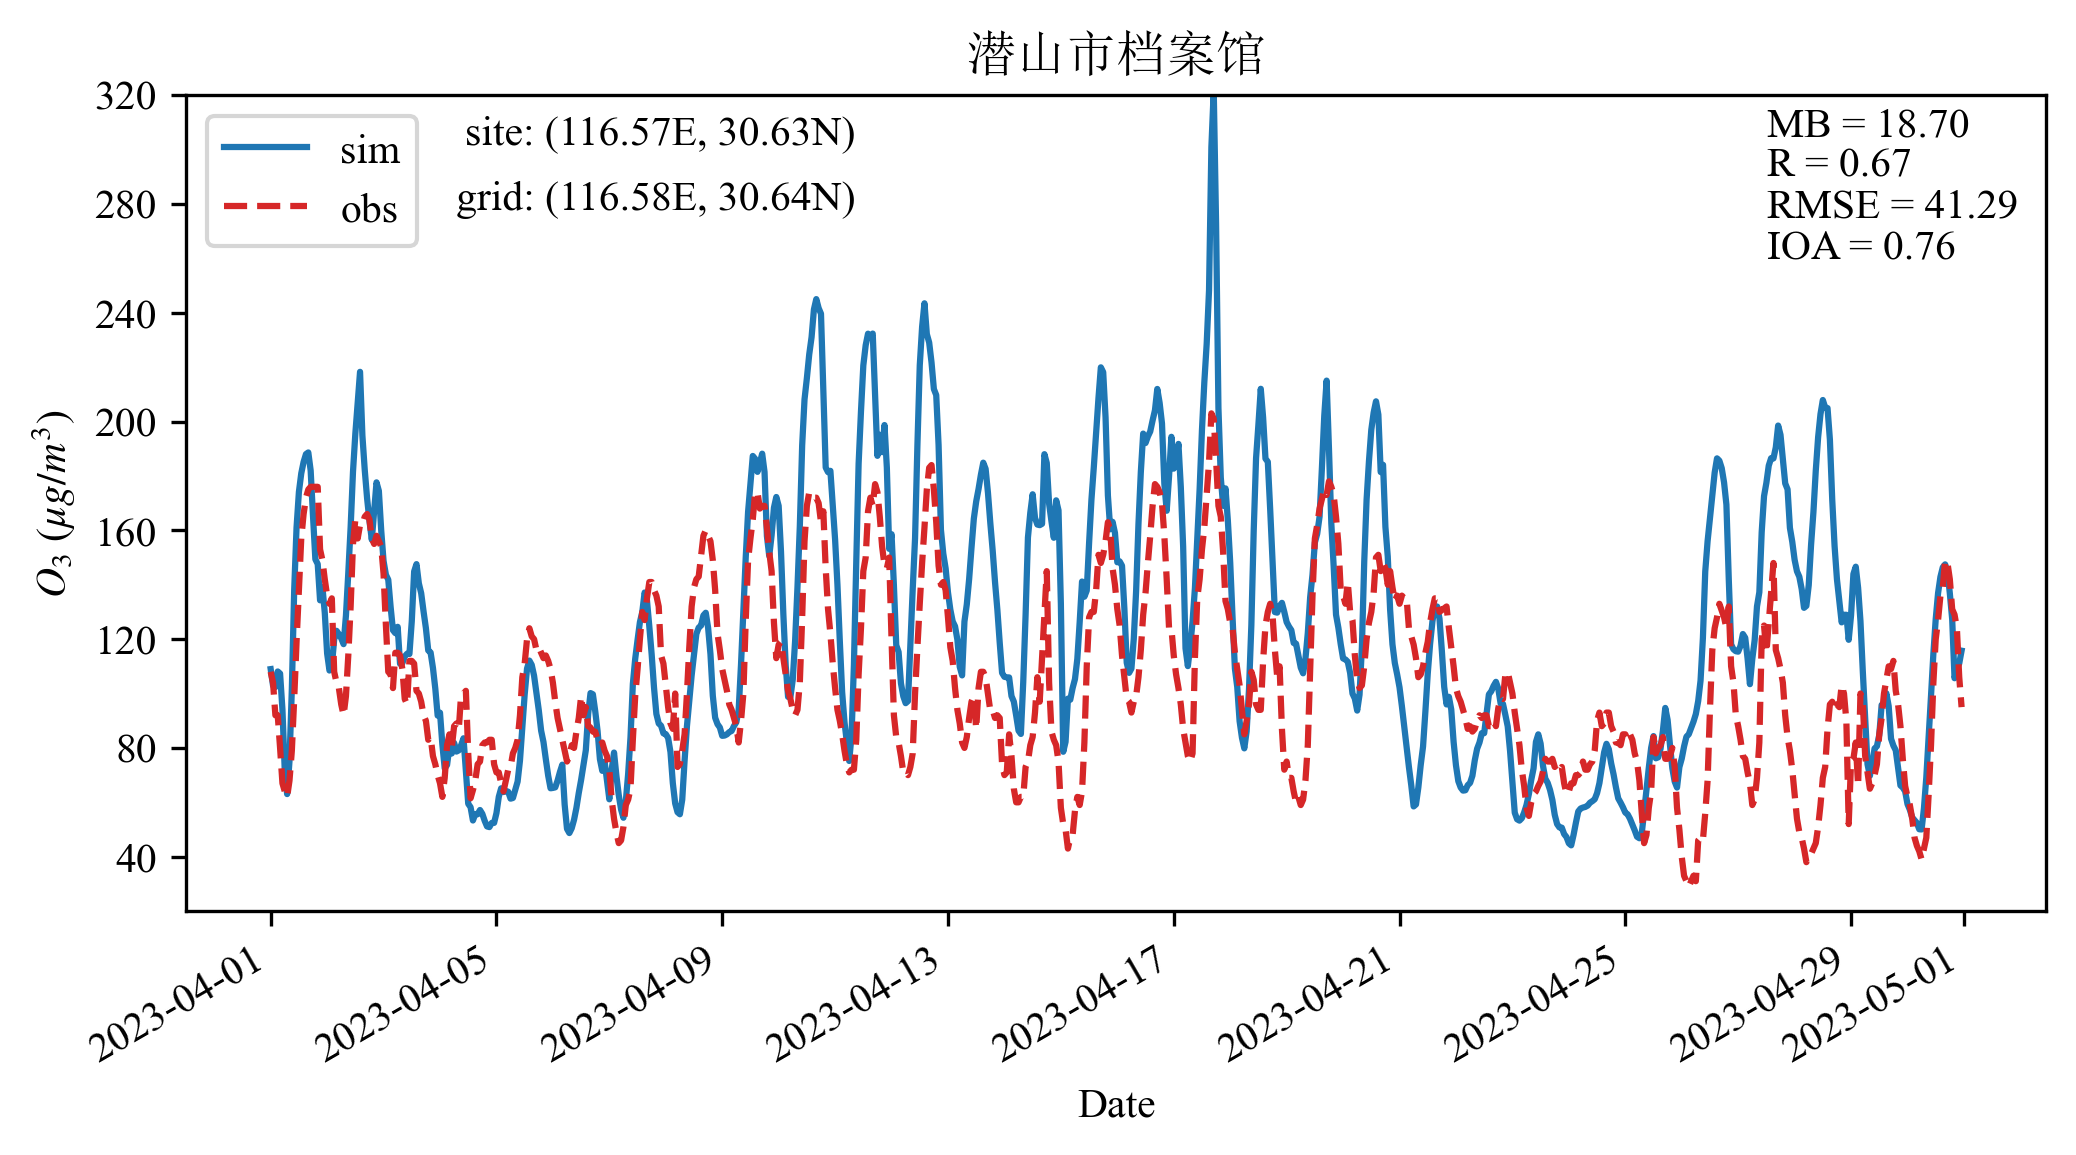

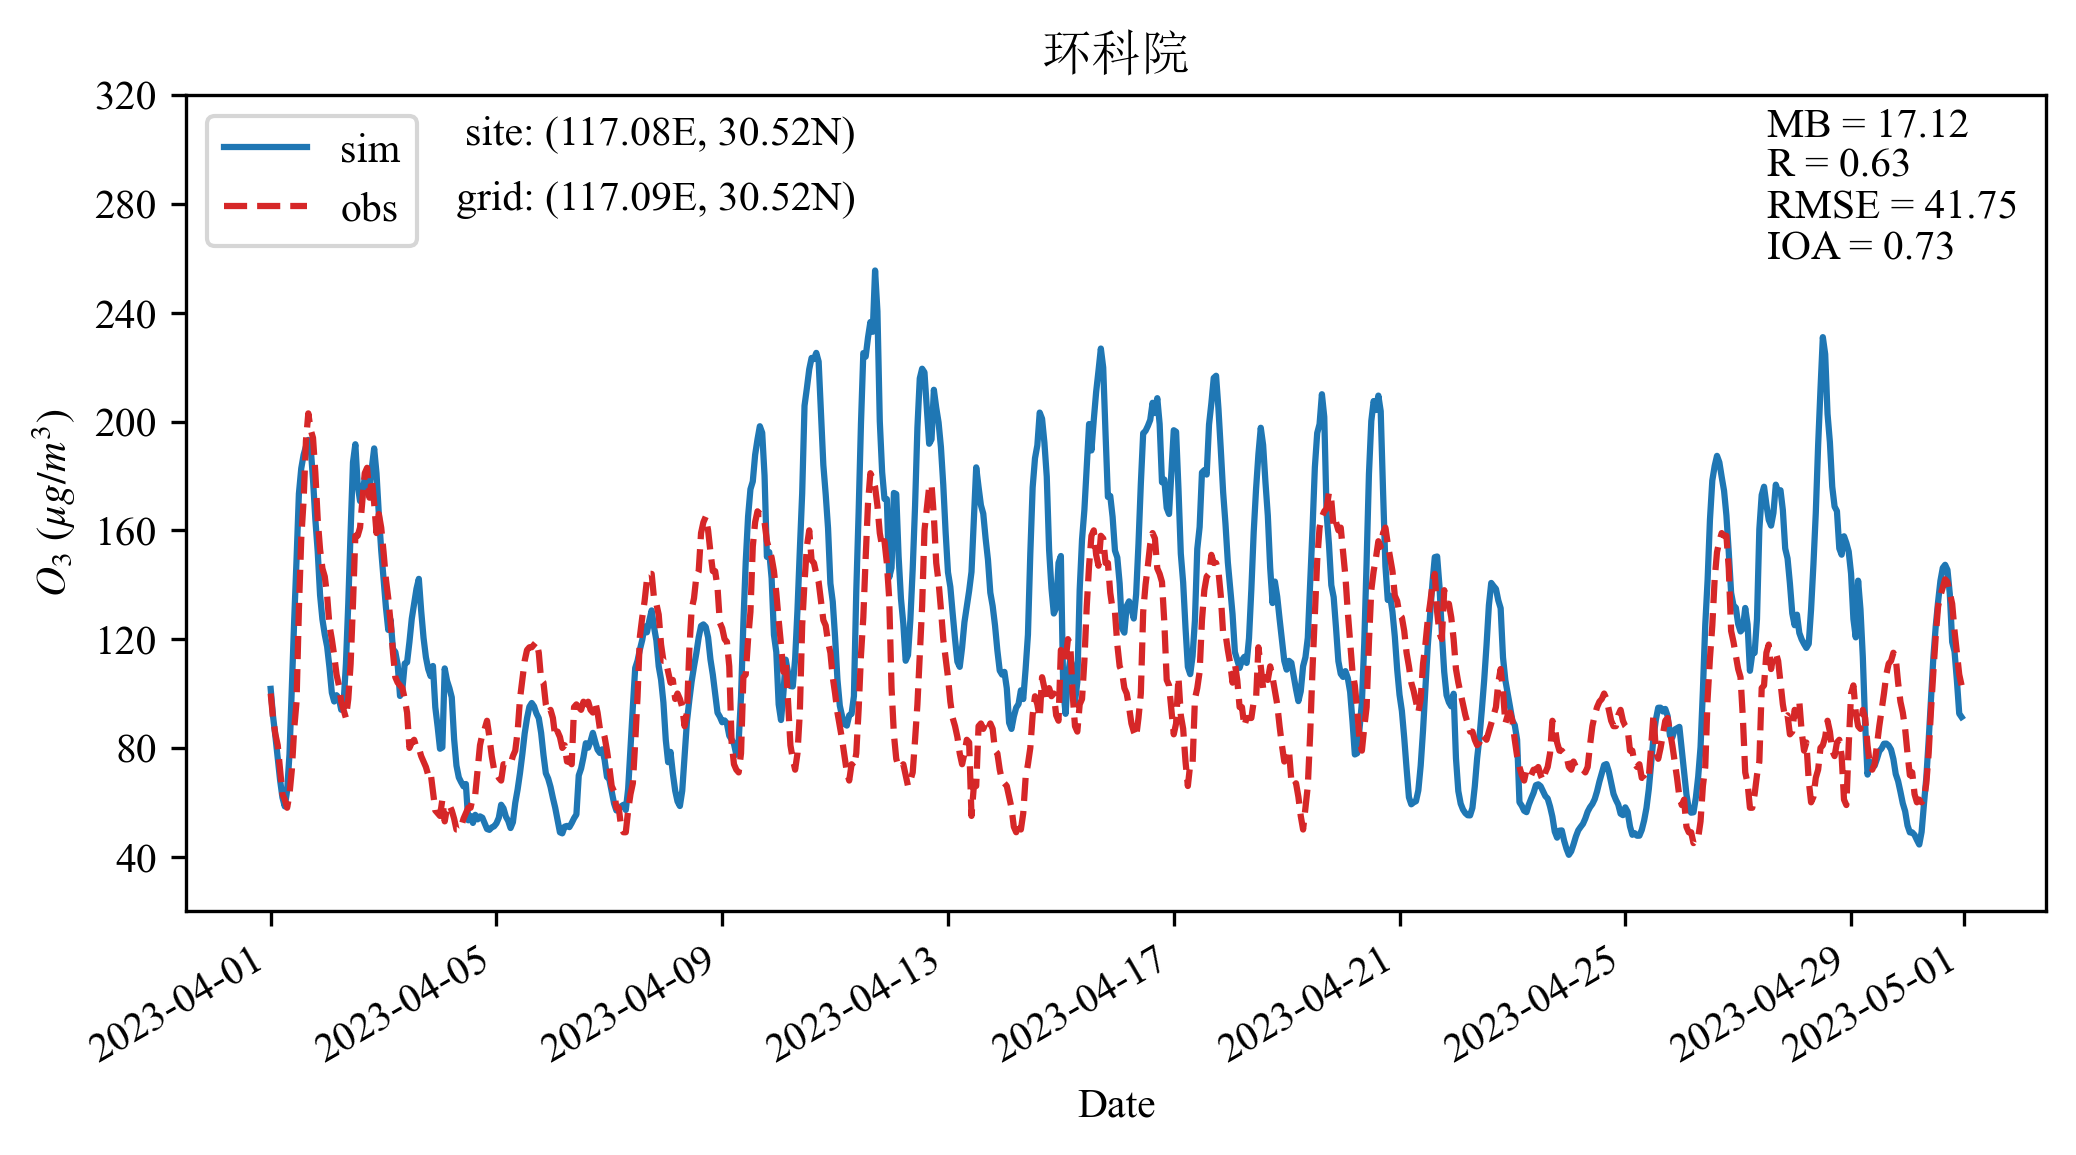

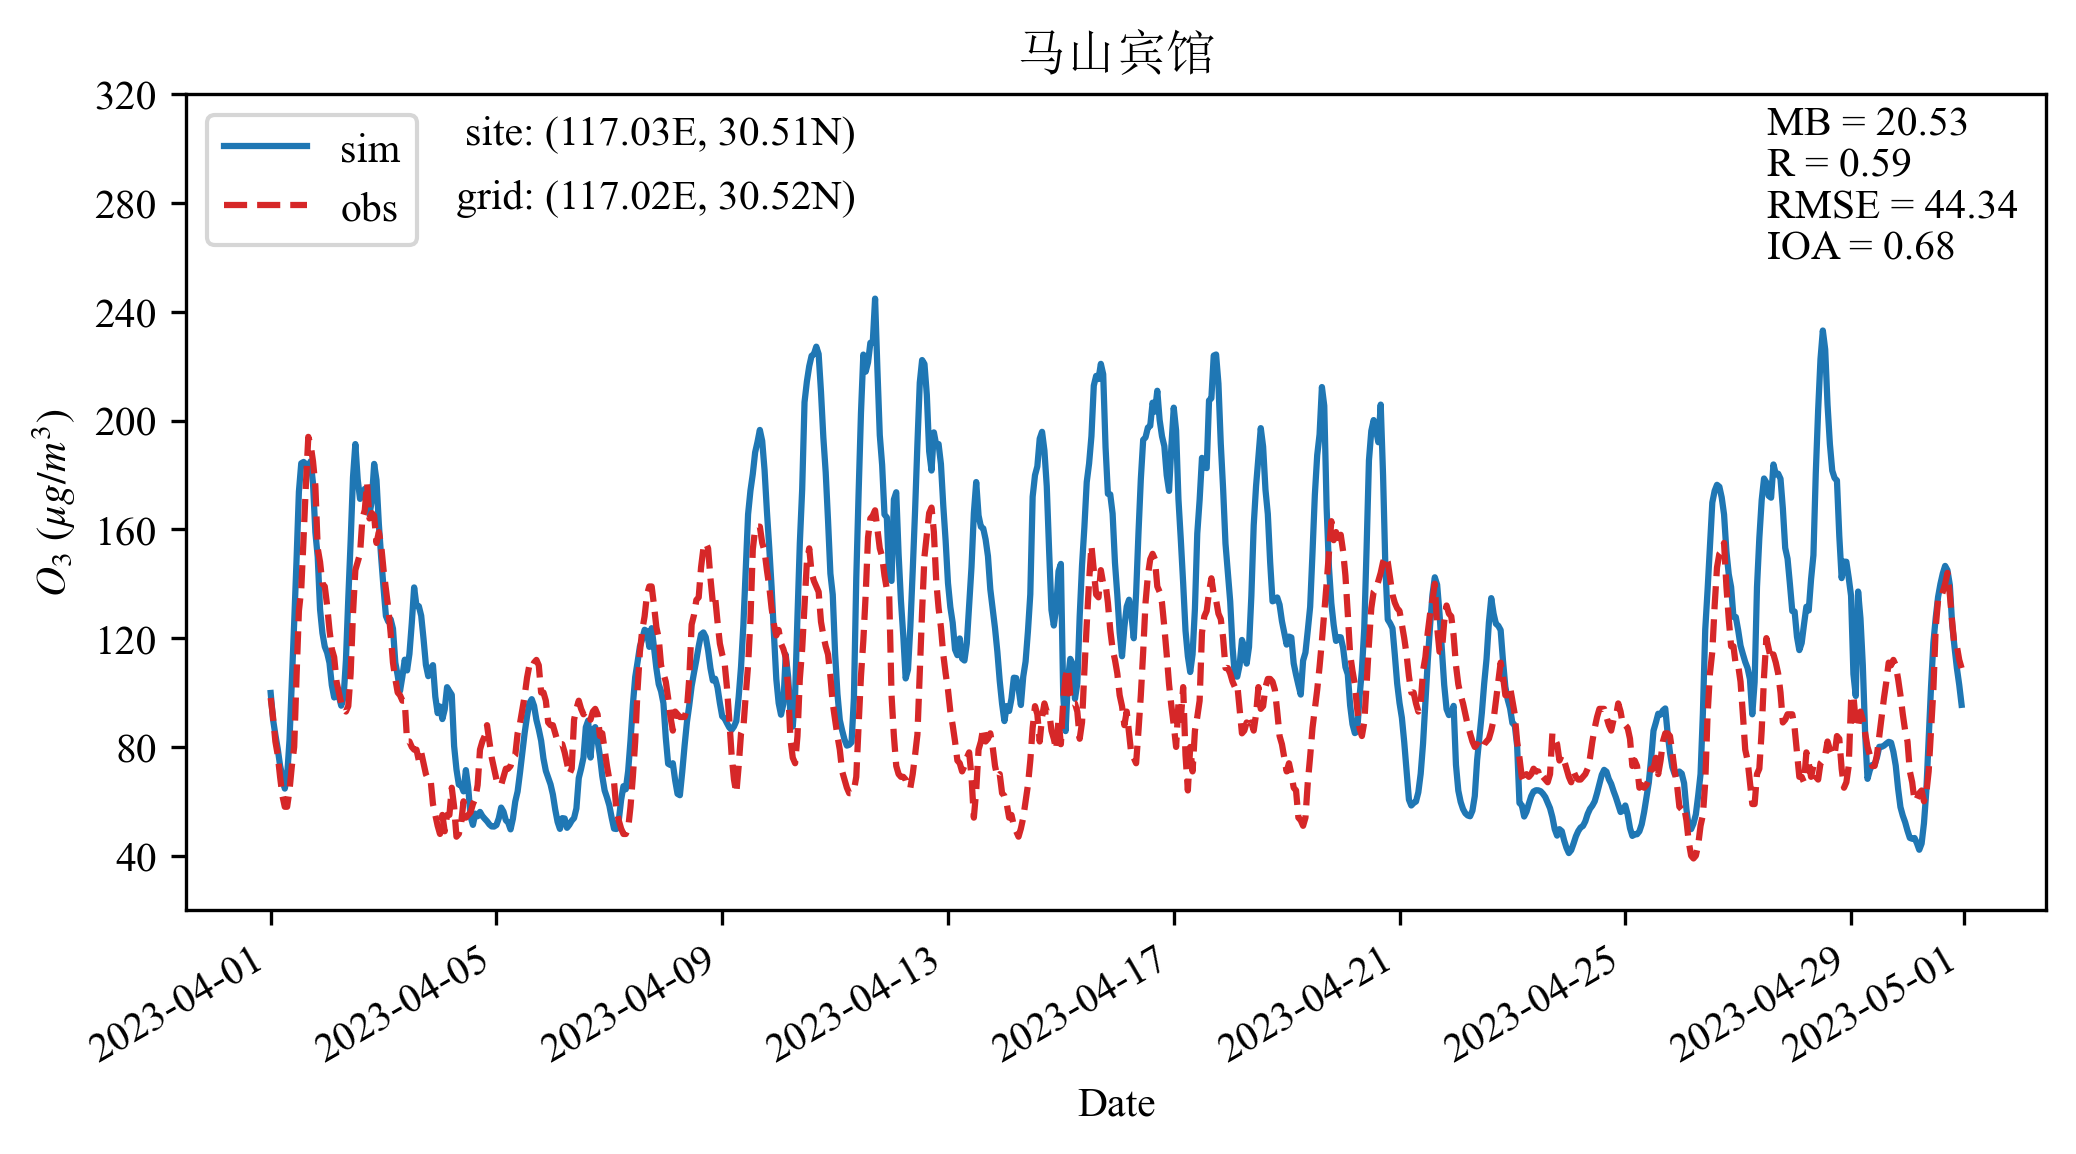

In [9]:
isite = 0
for name in sitename:
    fig = plt.figure(figsize=(8,4),dpi=300)
    ax = fig.subplots(1,1)
    sim = nr[:,0,isite,isite]
    obs = df[name]
    
    sim.plot(ax=ax,linestyle='-',label='sim',color='tab:blue')
    obs.plot(ax=ax,linestyle='--',label='obs',color='tab:red')
    
    mb = np.array(np.mean(sim)-np.mean(obs))
    r = pd.DataFrame({'A':sim,'B':obs}).corr().iloc[0,1]
    rmse = me.cal_RMSE(obs,sim.data)
    ioa = me.cal_IOA(obs,sim.data)
    
    ax.text(x=0.85,y=0.95,s='MB = '+str(f"{mb:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.9,s='R = '+str(f"{r:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.85,s='RMSE = '+str(f"{rmse:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.8,s='IOA = '+str(f"{ioa:.2f}"),ha='left',transform=ax.transAxes)

    ax.legend(loc=2)
    ax.set_title(name,fontdict={'fontfamily':'SimSun'})
    loctxt = 'site: ('+str(f"{lono[name]:.2f}")+'E, '+str(f"{lato[name]:.2f}")+'N)'
    gridtxt = 'grid: ('+str(f"{sim.longitude.data:.2f}")+'E, '+str(f"{sim.latitude.data:.2f}")+'N)'
    ax.text(x=0.36,y=0.94,s=loctxt,ha='right',transform=ax.transAxes)
    ax.text(x=0.36,y=0.86,s=gridtxt,ha='right',transform=ax.transAxes)
    ax.set_yticks(np.arange(0,321,40))
    ax.set_ylabel('$O_3$ ($\mu$$g/m^3$)')
    ax.set_xlabel('Date')
    ax.set_ylim(20,320)
    
    path = 'F:/Data/case_anqing/figure/April/逐站点/安庆O3NO2/'
    plt.savefig(path+name+'.png')
    
    isite += 1